***
<center><img src='https://github.com/HesamAsad/HesamAsad.github.io/blob/main/images/LOGO_EN_blue.png?raw=true' width=250/></center>

# <center>
## <center><span style='font-family:"Times New Roman"'><span style='background:dark'>  <font color='#1966ab'>$\LARGE{\text{Sharif University of Technology}}$</font>  <br>  <br>  <font color='#FFFFCC'>$\Large{\text{Masoud Tahmasbi}}$ </font> <br> <font color='#FFFFCC'>$\normalsize {\text{Student ID: } 402200275}$ </font>  <br>  <br> <font color='#33FFCC'>$\large{\text{EE577: Massive Data Analytics}}$</font> <br>  <font color='#FFFF00'>$\normalsize{\text{Final Project - Persian News Stream Processing}}$ </font>
<br>

***

# $\text{Environment Configuration}$

In [ ]:
import pyspark
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.streaming import StreamingContext

In [ ]:
spark = (SparkSession \
         .builder \
         .appName("stream") \
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/05 18:06:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
schema = StructType([
    StructField("author", StringType()),
    StructField("author_keyword", StringType()),
    StructField("body", StringType()),
    StructField("body_with_html", StringType()),
    StructField("body_with_html_keyword", StringType()),
    StructField("categories", ArrayType(
        StringType(),
    )),
    StructField("categories_keyword", StringType()),
    StructField("cluster_id", StringType()),
    StructField("cluster_id_keyword", StringType()),
    StructField("crawler_source", StringType()),
    StructField("crawler_source_keyword", StringType()),
    StructField("crawler_timestamp", LongType()),
    StructField("date_published", TimestampType()),
    StructField("hostname", StringType()),
    StructField("hostname_keyword", StringType()),
    StructField("hot_news", StringType()),
    StructField("hot_news_keyword", StringType()),
    StructField("images_url", StringType()),
    StructField("images_url_keyword", StringType()),
    StructField("ingestor_timestamp", LongType()),
    StructField("keywords", StringType()),
    StructField("keywords_keyword", StringType()),
    StructField("language", StringType()),
    StructField("ner_tags", ArrayType(StructType([
        StructField("entity", StringType()),
        StructField("entity_keyword", StringType()),
        StructField("type", StringType()),
        StructField("type_keyword", StringType())
    ]))),
    StructField("news_factual_new_type_text", StringType()),
    StructField("news_factual_news_type", StringType()),
    StructField("news_factual_news_type_text", StringType()),
    StructField("news_id", StringType()),
    StructField("news_id_keyword", StringType()),
    StructField("news_type", StringType()),
    StructField("news_type_keyword", StringType()),
    StructField("parser_categories", StringType()),
    StructField("parser_categories_keyword", StringType()),
    StructField("parser_keyword", StringType()),
    StructField("parser_keyword_keyword", StringType()),
    StructField("processed_body", StringType()),
    StructField("source", StringType()),
    StructField("source_id", LongType()),
    StructField("title", StringType()),
    StructField("uid", StringType()),
    StructField("url_hash", StringType()),
    StructField("url_hash_keyword", StringType())
])

In [ ]:
with open('news_data.jsonl', 'r') as f:
     lines = f.readlines()
     f.close()

count = 0
 for i in range(0, 627164, 2000):
     with open(f'streamdata/stream_part{count}.jsonl', 'w') as f:
         f.writelines(lines[i:i+2000])
         count += 1
         f.close()

In [ ]:
news0 = pd.read_json('streamdata/stream_part0.jsonl', lines=True)
news313 = pd.read_json('streamdata/stream_part313.jsonl', lines=True)
print('News started from:\t', datetime.fromtimestamp(news0['date_published'].min()))
print('News finished in:\t', datetime.fromtimestamp(news313['date_published'].max()))

News started from:	 2023-09-06 11:38:01
News finished in:	 2023-11-06 07:30:34


In [ ]:
news = spark.readStream.format('json').option('maxFilesPerTrigger', 1).schema(schema).load('./streamdata')

In [ ]:
news.isStreaming

True

In [ ]:
news.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_keyword: string (nullable = true)
 |-- body_with_html: string (nullable = true)
 |-- body_with_html_keyword: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- categories_keyword: string (nullable = true)
 |-- cluster_id: string (nullable = true)
 |-- cluster_id_keyword: string (nullable = true)
 |-- crawler_source: string (nullable = true)
 |-- crawler_source_keyword: string (nullable = true)
 |-- crawler_timestamp: long (nullable = true)
 |-- date_published: timestamp (nullable = true)
 |-- hostname: string (nullable = true)
 |-- hostname_keyword: string (nullable = true)
 |-- hot_news: string (nullable = true)
 |-- hot_news_keyword: string (nullable = true)
 |-- images_url: string (nullable = true)
 |-- images_url_keyword: string (nullable = true)
 |-- ingestor_timestamp: long (nullable = true)
 |-- keywords: string (nullable = true)
 |-- keywords_keyword: strin

***
# $\text{Step 1}$

In [ ]:
from pyspark.sql.functions import explode

news_exploded = news.withColumn("category", explode("categories"))

In [ ]:
kwrds_count = news_exploded.groupBy('category').agg(count('uid').alias('category_count')).sort(desc('category_count'))

In [ ]:
query = kwrds_count.writeStream.format('console').outputMode('complete').start(truncate=False)

24/02/05 14:13:33 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-111bd826-abc6-4fcf-bf9f-4091dd33efa5. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/02/05 14:13:33 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |783           |
|social                |537           |
|politics              |276           |
|sports                |232           |
|culture               |111           |
|health                |26            |
|science_and_technology|26            |
|religious             |5             |
|security              |3             |
|military              |1             |
+----------------------+--------------+



-------------------------------------------
Batch: 1
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |1621          |
|social                |969           |
|politics              |574           |
|sports                |523           |
|culture               |200           |
|health                |57            |
|science_and_technology|32            |
|religious             |14            |
|security              |8             |
|military              |2             |
+----------------------+--------------+



-------------------------------------------
Batch: 2
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |2498          |
|social                |1396          |
|politics              |866           |
|sports                |754           |
|culture               |287           |
|health                |118           |
|science_and_technology|50            |
|religious             |17            |
|security              |9             |
|military              |5             |
+----------------------+--------------+



-------------------------------------------
Batch: 3
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |3273          |
|social                |1874          |
|politics              |1181          |
|sports                |1058          |
|culture               |363           |
|health                |147           |
|science_and_technology|62            |
|religious             |18            |
|security              |16            |
|military              |8             |
+----------------------+--------------+



-------------------------------------------
Batch: 4
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |4068          |
|social                |2253          |
|politics              |1478          |
|sports                |1469          |
|culture               |427           |
|health                |189           |
|science_and_technology|70            |
|religious             |19            |
|security              |18            |
|military              |9             |
+----------------------+--------------+



-------------------------------------------
Batch: 5
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |4770          |
|social                |2746          |
|politics              |1849          |
|sports                |1680          |
|culture               |578           |
|health                |230           |
|science_and_technology|97            |
|religious             |21            |
|security              |19            |
|military              |10            |
+----------------------+--------------+



-------------------------------------------
Batch: 6
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |5488          |
|social                |3301          |
|politics              |2130          |
|sports                |1924          |
|culture               |728           |
|health                |261           |
|science_and_technology|114           |
|security              |22            |
|religious             |22            |
|military              |10            |
+----------------------+--------------+



-------------------------------------------
Batch: 7
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |6366          |
|social                |3692          |
|politics              |2398          |
|sports                |2221          |
|culture               |825           |
|health                |315           |
|science_and_technology|123           |
|religious             |26            |
|security              |22            |
|military              |12            |
+----------------------+--------------+



-------------------------------------------
Batch: 8
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |7016          |
|social                |4252          |
|politics              |2640          |
|sports                |2527          |
|culture               |992           |
|health                |366           |
|science_and_technology|139           |
|religious             |28            |
|security              |22            |
|military              |18            |
+----------------------+--------------+



-------------------------------------------
Batch: 9
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |7885          |
|social                |4617          |
|politics              |2946          |
|sports                |2853          |
|culture               |1075          |
|health                |402           |
|science_and_technology|145           |
|religious             |34            |
|security              |23            |
|military              |20            |
+----------------------+--------------+



-------------------------------------------
Batch: 10
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |8758          |
|social                |4975          |
|politics              |3280          |
|sports                |3155          |
|culture               |1166          |
|health                |434           |
|science_and_technology|154           |
|religious             |35            |
|security              |23            |
|military              |20            |
+----------------------+--------------+



-------------------------------------------
Batch: 11
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |9495          |
|social                |5478          |
|politics              |3584          |
|sports                |3438          |
|culture               |1286          |
|health                |470           |
|science_and_technology|166           |
|religious             |36            |
|military              |24            |
|security              |23            |
+----------------------+--------------+



-------------------------------------------
Batch: 12
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |10176         |
|social                |6026          |
|politics              |3903          |
|sports                |3741          |
|culture               |1400          |
|health                |492           |
|science_and_technology|175           |
|religious             |38            |
|security              |25            |
|military              |24            |
+----------------------+--------------+



-------------------------------------------
Batch: 13
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |10892         |
|social                |6499          |
|politics              |4249          |
|sports                |4065          |
|culture               |1498          |
|health                |520           |
|science_and_technology|182           |
|religious             |42            |
|security              |27            |
|military              |26            |
+----------------------+--------------+



-------------------------------------------
Batch: 14
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |11567         |
|social                |7048          |
|politics              |4556          |
|sports                |4312          |
|culture               |1661          |
|health                |555           |
|science_and_technology|200           |
|religious             |44            |
|military              |29            |
|security              |28            |
+----------------------+--------------+



-------------------------------------------
Batch: 15
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |12238         |
|social                |7632          |
|politics              |4855          |
|sports                |4562          |
|culture               |1796          |
|health                |581           |
|science_and_technology|226           |
|religious             |48            |
|security              |33            |
|military              |29            |
+----------------------+--------------+



-------------------------------------------
Batch: 16
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |12950         |
|social                |8208          |
|politics              |5103          |
|sports                |4816          |
|culture               |1939          |
|health                |625           |
|science_and_technology|242           |
|religious             |51            |
|security              |37            |
|military              |29            |
+----------------------+--------------+



-------------------------------------------
Batch: 17
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |13670         |
|social                |8833          |
|politics              |5366          |
|sports                |5024          |
|culture               |2060          |
|health                |664           |
|science_and_technology|262           |
|religious             |54            |
|security              |37            |
|military              |30            |
+----------------------+--------------+



-------------------------------------------
Batch: 18
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |14457         |
|social                |9306          |
|politics              |5673          |
|sports                |5277          |
|culture               |2174          |
|health                |715           |
|science_and_technology|273           |
|religious             |55            |
|security              |37            |
|military              |33            |
+----------------------+--------------+



-------------------------------------------
Batch: 19
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |15200         |
|social                |9805          |
|politics              |5976          |
|sports                |5577          |
|culture               |2265          |
|health                |758           |
|science_and_technology|287           |
|religious             |57            |
|security              |38            |
|military              |37            |
+----------------------+--------------+



-------------------------------------------
Batch: 20
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |15853         |
|social                |10393         |
|politics              |6300          |
|sports                |5870          |
|culture               |2354          |
|health                |791           |
|science_and_technology|296           |
|religious             |65            |
|security              |39            |
|military              |39            |
+----------------------+--------------+



-------------------------------------------
Batch: 21
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |16513         |
|social                |10970         |
|politics              |6614          |
|sports                |6144          |
|culture               |2464          |
|health                |827           |
|science_and_technology|308           |
|religious             |75            |
|security              |43            |
|military              |42            |
+----------------------+--------------+



-------------------------------------------
Batch: 22
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |17357         |
|social                |11247         |
|politics              |6920          |
|sports                |6555          |
|culture               |2578          |
|health                |856           |
|science_and_technology|319           |
|religious             |80            |
|security              |44            |
|military              |44            |
+----------------------+--------------+



-------------------------------------------
Batch: 23
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |18056         |
|social                |11755         |
|politics              |7250          |
|sports                |6785          |
|culture               |2756          |
|health                |894           |
|science_and_technology|330           |
|religious             |82            |
|military              |48            |
|security              |44            |
+----------------------+--------------+



-------------------------------------------
Batch: 24
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |18868         |
|social                |12056         |
|politics              |7677          |
|sports                |7101          |
|culture               |2833          |
|health                |933           |
|science_and_technology|345           |
|religious             |89            |
|military              |50            |
|security              |48            |
+----------------------+--------------+



-------------------------------------------
Batch: 25
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |19607         |
|social                |12562         |
|politics              |8017          |
|sports                |7320          |
|culture               |2958          |
|health                |971           |
|science_and_technology|367           |
|religious             |99            |
|military              |50            |
|security              |49            |
+----------------------+--------------+



-------------------------------------------
Batch: 26
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |20346         |
|social                |13013         |
|politics              |8374          |
|sports                |7523          |
|culture               |3141          |
|health                |1008          |
|science_and_technology|391           |
|religious             |103           |
|military              |51            |
|security              |50            |
+----------------------+--------------+



-------------------------------------------
Batch: 27
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |21119         |
|social                |13484         |
|politics              |8702          |
|sports                |7763          |
|culture               |3268          |
|health                |1046          |
|science_and_technology|403           |
|religious             |113           |
|security              |51            |
|military              |51            |
+----------------------+--------------+



-------------------------------------------
Batch: 28
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |21874         |
|social                |13959         |
|politics              |9025          |
|sports                |8014          |
|culture               |3403          |
|health                |1084          |
|science_and_technology|419           |
|religious             |115           |
|security              |55            |
|military              |52            |
+----------------------+--------------+



-------------------------------------------
Batch: 29
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |22622         |
|social                |14347         |
|politics              |9332          |
|sports                |8404          |
|culture               |3528          |
|health                |1114          |
|science_and_technology|429           |
|religious             |116           |
|security              |56            |
|military              |52            |
+----------------------+--------------+



-------------------------------------------
Batch: 30
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |23424         |
|social                |14746         |
|politics              |9645          |
|sports                |8655          |
|culture               |3677          |
|health                |1166          |
|science_and_technology|448           |
|religious             |128           |
|security              |59            |
|military              |52            |
+----------------------+--------------+



-------------------------------------------
Batch: 31
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |24175         |
|social                |15260         |
|politics              |9952          |
|sports                |8890          |
|culture               |3826          |
|health                |1185          |
|science_and_technology|465           |
|religious             |130           |
|security              |62            |
|military              |55            |
+----------------------+--------------+



-------------------------------------------
Batch: 32
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |24911         |
|social                |15753         |
|politics              |10286         |
|sports                |9114          |
|culture               |3968          |
|health                |1225          |
|science_and_technology|494           |
|religious             |131           |
|security              |63            |
|military              |55            |
+----------------------+--------------+



-------------------------------------------
Batch: 33
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |25694         |
|social                |16211         |
|politics              |10629         |
|sports                |9378          |
|culture               |4059          |
|health                |1269          |
|science_and_technology|504           |
|religious             |135           |
|security              |64            |
|military              |57            |
+----------------------+--------------+



-------------------------------------------
Batch: 34
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |26538         |
|social                |16588         |
|politics              |10966         |
|sports                |9705          |
|culture               |4131          |
|health                |1295          |
|science_and_technology|515           |
|religious             |136           |
|security              |68            |
|military              |58            |
+----------------------+--------------+



-------------------------------------------
Batch: 35
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |27442         |
|social                |16937         |
|politics              |11242         |
|sports                |10026         |
|culture               |4218          |
|health                |1342          |
|science_and_technology|525           |
|religious             |141           |
|security              |68            |
|military              |59            |
+----------------------+--------------+



-------------------------------------------
Batch: 36
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |28184         |
|social                |17368         |
|politics              |11599         |
|sports                |10289         |
|culture               |4351          |
|health                |1376          |
|science_and_technology|545           |
|religious             |157           |
|security              |70            |
|military              |61            |
+----------------------+--------------+



-------------------------------------------
Batch: 37
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |29095         |
|social                |17621         |
|politics              |11931         |
|sports                |10663         |
|culture               |4422          |
|health                |1414          |
|science_and_technology|555           |
|religious             |167           |
|security              |70            |
|military              |62            |
+----------------------+--------------+



-------------------------------------------
Batch: 38
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |30013         |
|social                |17946         |
|politics              |12224         |
|sports                |10975         |
|culture               |4509          |
|health                |1471          |
|science_and_technology|556           |
|religious             |170           |
|security              |73            |
|military              |63            |
+----------------------+--------------+



-------------------------------------------
Batch: 39
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |30868         |
|social                |18332         |
|politics              |12587         |
|sports                |11210         |
|culture               |4605          |
|health                |1523          |
|science_and_technology|568           |
|religious             |171           |
|security              |73            |
|military              |63            |
+----------------------+--------------+



-------------------------------------------
Batch: 40
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |31668         |
|social                |18733         |
|politics              |12915         |
|sports                |11554         |
|culture               |4677          |
|health                |1550          |
|science_and_technology|580           |
|religious             |183           |
|security              |75            |
|military              |65            |
+----------------------+--------------+



-------------------------------------------
Batch: 41
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |32609         |
|social                |19064         |
|politics              |13219         |
|sports                |11808         |
|culture               |4788          |
|health                |1601          |
|science_and_technology|585           |
|religious             |184           |
|security              |77            |
|military              |65            |
+----------------------+--------------+



-------------------------------------------
Batch: 42
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |33412         |
|social                |19467         |
|politics              |13526         |
|sports                |12088         |
|culture               |4914          |
|health                |1639          |
|science_and_technology|606           |
|religious             |199           |
|security              |79            |
|military              |70            |
+----------------------+--------------+



-------------------------------------------
Batch: 43
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |34157         |
|social                |19994         |
|politics              |13816         |
|sports                |12369         |
|culture               |5012          |
|health                |1678          |
|science_and_technology|623           |
|religious             |199           |
|security              |80            |
|military              |72            |
+----------------------+--------------+



-------------------------------------------
Batch: 44
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |34894         |
|social                |20420         |
|politics              |14178         |
|sports                |12715         |
|culture               |5093          |
|health                |1706          |
|science_and_technology|635           |
|religious             |205           |
|security              |81            |
|military              |73            |
+----------------------+--------------+



-------------------------------------------
Batch: 45
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |35610         |
|social                |20911         |
|politics              |14558         |
|sports                |12924         |
|culture               |5222          |
|health                |1748          |
|science_and_technology|652           |
|religious             |208           |
|security              |91            |
|military              |76            |
+----------------------+--------------+



-------------------------------------------
Batch: 46
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |36401         |
|social                |21273         |
|politics              |14866         |
|sports                |13225         |
|culture               |5379          |
|health                |1793          |
|science_and_technology|667           |
|religious             |219           |
|security              |100           |
|military              |77            |
+----------------------+--------------+



-------------------------------------------
Batch: 47
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |37205         |
|social                |21636         |
|politics              |15176         |
|sports                |13624         |
|culture               |5459          |
|health                |1830          |
|science_and_technology|672           |
|religious             |219           |
|security              |101           |
|military              |78            |
+----------------------+--------------+



-------------------------------------------
Batch: 48
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |37877         |
|social                |22134         |
|politics              |15531         |
|sports                |13895         |
|culture               |5616          |
|health                |1851          |
|science_and_technology|695           |
|religious             |220           |
|security              |102           |
|military              |79            |
+----------------------+--------------+



-------------------------------------------
Batch: 49
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |38687         |
|social                |22471         |
|politics              |15883         |
|sports                |14264         |
|culture               |5690          |
|health                |1894          |
|science_and_technology|707           |
|religious             |220           |
|security              |105           |
|military              |79            |
+----------------------+--------------+



-------------------------------------------
Batch: 50
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |39514         |
|social                |22935         |
|politics              |16137         |
|sports                |14515         |
|culture               |5835          |
|health                |1930          |
|science_and_technology|726           |
|religious             |221           |
|security              |105           |
|military              |82            |
+----------------------+--------------+



-------------------------------------------
Batch: 51
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |40283         |
|social                |23412         |
|politics              |16415         |
|sports                |14751         |
|culture               |6013          |
|health                |1975          |
|science_and_technology|740           |
|religious             |221           |
|security              |108           |
|military              |82            |
+----------------------+--------------+



-------------------------------------------
Batch: 52
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |41050         |
|social                |23849         |
|politics              |16727         |
|sports                |15084         |
|culture               |6099          |
|health                |2011          |
|science_and_technology|749           |
|religious             |236           |
|security              |109           |
|military              |86            |
+----------------------+--------------+



-------------------------------------------
Batch: 53
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |41839         |
|social                |24330         |
|politics              |17033         |
|sports                |15310         |
|culture               |6234          |
|health                |2050          |
|science_and_technology|764           |
|religious             |242           |
|security              |110           |
|military              |88            |
+----------------------+--------------+



-------------------------------------------
Batch: 54
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |42646         |
|social                |24769         |
|politics              |17396         |
|sports                |15532         |
|culture               |6339          |
|health                |2099          |
|science_and_technology|776           |
|religious             |242           |
|security              |113           |
|military              |88            |
+----------------------+--------------+



-------------------------------------------
Batch: 55
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |43561         |
|social                |25041         |
|politics              |17737         |
|sports                |15850         |
|culture               |6432          |
|health                |2145          |
|science_and_technology|785           |
|religious             |244           |
|security              |117           |
|military              |88            |
+----------------------+--------------+



-------------------------------------------
Batch: 56
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |44300         |
|social                |25560         |
|politics              |18051         |
|sports                |16065         |
|culture               |6588          |
|health                |2183          |
|science_and_technology|800           |
|religious             |246           |
|security              |119           |
|military              |88            |
+----------------------+--------------+



-------------------------------------------
Batch: 57
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |45032         |
|social                |26043         |
|politics              |18370         |
|sports                |16348         |
|culture               |6713          |
|health                |2219          |
|science_and_technology|809           |
|religious             |249           |
|security              |127           |
|military              |90            |
+----------------------+--------------+



-------------------------------------------
Batch: 58
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |45903         |
|social                |26303         |
|politics              |18759         |
|sports                |16670         |
|culture               |6804          |
|health                |2272          |
|science_and_technology|819           |
|religious             |250           |
|security              |130           |
|military              |90            |
+----------------------+--------------+



-------------------------------------------
Batch: 59
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |46651         |
|social                |26757         |
|politics              |19117         |
|sports                |16906         |
|culture               |6937          |
|health                |2314          |
|science_and_technology|842           |
|religious             |250           |
|security              |135           |
|military              |91            |
+----------------------+--------------+



-------------------------------------------
Batch: 60
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |47384         |
|social                |27066         |
|politics              |19491         |
|sports                |17322         |
|culture               |7063          |
|health                |2337          |
|science_and_technology|855           |
|religious             |252           |
|security              |137           |
|military              |93            |
+----------------------+--------------+



-------------------------------------------
Batch: 61
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |48118         |
|social                |27475         |
|politics              |19854         |
|sports                |17655         |
|culture               |7173          |
|health                |2365          |
|science_and_technology|871           |
|religious             |256           |
|security              |139           |
|military              |94            |
+----------------------+--------------+



-------------------------------------------
Batch: 62
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |48864         |
|social                |27933         |
|politics              |20204         |
|sports                |17877         |
|culture               |7353          |
|health                |2390          |
|science_and_technology|884           |
|religious             |257           |
|security              |143           |
|military              |95            |
+----------------------+--------------+



-------------------------------------------
Batch: 63
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |49548         |
|social                |28463         |
|politics              |20614         |
|sports                |18054         |
|culture               |7499          |
|health                |2423          |
|science_and_technology|900           |
|religious             |258           |
|security              |144           |
|military              |97            |
+----------------------+--------------+



-------------------------------------------
Batch: 64
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |50274         |
|social                |28914         |
|politics              |21018         |
|sports                |18346         |
|culture               |7583          |
|health                |2450          |
|science_and_technology|908           |
|religious             |259           |
|security              |151           |
|military              |97            |
+----------------------+--------------+



-------------------------------------------
Batch: 65
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |50985         |
|social                |29303         |
|politics              |21466         |
|sports                |18626         |
|culture               |7681          |
|health                |2485          |
|science_and_technology|926           |
|religious             |259           |
|security              |171           |
|military              |98            |
+----------------------+--------------+



-------------------------------------------
Batch: 66
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |51725         |
|social                |29718         |
|politics              |21809         |
|sports                |18981         |
|culture               |7785          |
|health                |2509          |
|science_and_technology|936           |
|religious             |264           |
|security              |174           |
|military              |99            |
+----------------------+--------------+



-------------------------------------------
Batch: 67
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |52471         |
|social                |30221         |
|politics              |22109         |
|sports                |19217         |
|culture               |7942          |
|health                |2536          |
|science_and_technology|962           |
|religious             |265           |
|security              |178           |
|military              |99            |
+----------------------+--------------+



-------------------------------------------
Batch: 68
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |53215         |
|social                |30680         |
|politics              |22492         |
|sports                |19432         |
|culture               |8093          |
|health                |2563          |
|science_and_technology|981           |
|religious             |267           |
|security              |178           |
|military              |99            |
+----------------------+--------------+



-------------------------------------------
Batch: 69
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |54019         |
|social                |30980         |
|politics              |22819         |
|sports                |19864         |
|culture               |8171          |
|health                |2610          |
|science_and_technology|989           |
|religious             |269           |
|security              |180           |
|military              |99            |
+----------------------+--------------+



-------------------------------------------
Batch: 70
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |54932         |
|social                |31256         |
|politics              |23163         |
|sports                |20199         |
|culture               |8246          |
|health                |2641          |
|science_and_technology|1003          |
|religious             |272           |
|security              |188           |
|military              |100           |
+----------------------+--------------+



-------------------------------------------
Batch: 71
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |55892         |
|social                |31583         |
|politics              |23459         |
|sports                |20486         |
|culture               |8316          |
|health                |2682          |
|science_and_technology|1012          |
|religious             |278           |
|security              |189           |
|military              |103           |
+----------------------+--------------+



-------------------------------------------
Batch: 72
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |56711         |
|social                |31918         |
|politics              |23779         |
|sports                |20854         |
|culture               |8419          |
|health                |2721          |
|science_and_technology|1020          |
|religious             |285           |
|security              |189           |
|military              |104           |
+----------------------+--------------+



-------------------------------------------
Batch: 73
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |57585         |
|social                |32295         |
|politics              |24114         |
|sports                |21116         |
|culture               |8516          |
|health                |2762          |
|science_and_technology|1028          |
|religious             |288           |
|security              |191           |
|military              |105           |
+----------------------+--------------+



-------------------------------------------
Batch: 74
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |58473         |
|social                |32614         |
|politics              |24462         |
|sports                |21400         |
|culture               |8631          |
|health                |2791          |
|science_and_technology|1036          |
|religious             |290           |
|security              |198           |
|military              |105           |
+----------------------+--------------+



-------------------------------------------
Batch: 75
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |59224         |
|social                |32911         |
|politics              |24791         |
|sports                |21874         |
|culture               |8722          |
|health                |2824          |
|science_and_technology|1050          |
|religious             |297           |
|security              |199           |
|military              |108           |
+----------------------+--------------+



-------------------------------------------
Batch: 76
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |60033         |
|social                |33371         |
|politics              |25115         |
|sports                |22105         |
|culture               |8838          |
|health                |2868          |
|science_and_technology|1060          |
|religious             |300           |
|security              |201           |
|military              |109           |
+----------------------+--------------+



-------------------------------------------
Batch: 77
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |60820         |
|social                |33730         |
|politics              |25435         |
|sports                |22478         |
|culture               |8944          |
|health                |2903          |
|science_and_technology|1070          |
|religious             |308           |
|security              |203           |
|military              |109           |
+----------------------+--------------+



-------------------------------------------
Batch: 78
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |61631         |
|social                |34125         |
|politics              |25780         |
|sports                |22783         |
|culture               |9039          |
|health                |2937          |
|science_and_technology|1080          |
|religious             |310           |
|security              |204           |
|military              |111           |
+----------------------+--------------+



-------------------------------------------
Batch: 79
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |62391         |
|social                |34475         |
|politics              |26196         |
|sports                |23108         |
|culture               |9138          |
|health                |2973          |
|science_and_technology|1089          |
|religious             |312           |
|security              |205           |
|military              |113           |
+----------------------+--------------+



-------------------------------------------
Batch: 80
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |63213         |
|social                |34816         |
|politics              |26540         |
|sports                |23444         |
|culture               |9246          |
|health                |3003          |
|science_and_technology|1100          |
|religious             |320           |
|security              |205           |
|military              |113           |
+----------------------+--------------+



-------------------------------------------
Batch: 81
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |64125         |
|social                |35148         |
|politics              |26858         |
|sports                |23740         |
|culture               |9350          |
|health                |3022          |
|science_and_technology|1115          |
|religious             |322           |
|security              |205           |
|military              |115           |
+----------------------+--------------+



-------------------------------------------
Batch: 82
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |64844         |
|social                |35541         |
|politics              |27210         |
|sports                |24079         |
|culture               |9476          |
|health                |3068          |
|science_and_technology|1131          |
|religious             |324           |
|security              |211           |
|military              |116           |
+----------------------+--------------+



-------------------------------------------
Batch: 83
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |65647         |
|social                |35914         |
|politics              |27587         |
|sports                |24367         |
|culture               |9592          |
|health                |3097          |
|science_and_technology|1140          |
|religious             |326           |
|security              |214           |
|military              |116           |
+----------------------+--------------+



-------------------------------------------
Batch: 84
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |66404         |
|social                |36304         |
|politics              |27900         |
|sports                |24772         |
|culture               |9681          |
|health                |3130          |
|science_and_technology|1149          |
|religious             |327           |
|security              |216           |
|military              |117           |
+----------------------+--------------+



-------------------------------------------
Batch: 85
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |67281         |
|social                |36636         |
|politics              |28207         |
|sports                |25102         |
|culture               |9785          |
|health                |3169          |
|science_and_technology|1157          |
|religious             |330           |
|security              |216           |
|military              |117           |
+----------------------+--------------+



-------------------------------------------
Batch: 86
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |68125         |
|social                |37004         |
|politics              |28533         |
|sports                |25389         |
|culture               |9903          |
|health                |3199          |
|science_and_technology|1173          |
|religious             |334           |
|security              |219           |
|military              |121           |
+----------------------+--------------+



-------------------------------------------
Batch: 87
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |68870         |
|social                |37338         |
|politics              |29066         |
|sports                |25664         |
|culture               |9972          |
|health                |3232          |
|science_and_technology|1173          |
|religious             |336           |
|security              |223           |
|military              |126           |
+----------------------+--------------+



-------------------------------------------
Batch: 88
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |69709         |
|social                |37762         |
|politics              |29392         |
|sports                |25962         |
|culture               |10032         |
|health                |3263          |
|science_and_technology|1183          |
|religious             |343           |
|security              |226           |
|military              |128           |
+----------------------+--------------+



-------------------------------------------
Batch: 89
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |70605         |
|social                |38038         |
|politics              |29783         |
|sports                |26300         |
|culture               |10093         |
|health                |3285          |
|science_and_technology|1193          |
|religious             |345           |
|security              |228           |
|military              |130           |
+----------------------+--------------+



-------------------------------------------
Batch: 90
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |71439         |
|social                |38407         |
|politics              |30077         |
|sports                |26675         |
|culture               |10177         |
|health                |3323          |
|science_and_technology|1197          |
|religious             |346           |
|security              |228           |
|military              |131           |
+----------------------+--------------+



-------------------------------------------
Batch: 91
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |72140         |
|social                |38702         |
|politics              |30350         |
|sports                |27267         |
|culture               |10255         |
|health                |3365          |
|science_and_technology|1201          |
|religious             |358           |
|security              |228           |
|military              |134           |
+----------------------+--------------+



-------------------------------------------
Batch: 92
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |72855         |
|social                |39011         |
|politics              |30742         |
|sports                |27740         |
|culture               |10324         |
|health                |3385          |
|science_and_technology|1213          |
|religious             |360           |
|security              |230           |
|military              |140           |
+----------------------+--------------+



-------------------------------------------
Batch: 93
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |73709         |
|social                |39347         |
|politics              |31049         |
|sports                |28088         |
|culture               |10424         |
|health                |3420          |
|science_and_technology|1224          |
|religious             |363           |
|security              |231           |
|military              |145           |
+----------------------+--------------+



-------------------------------------------
Batch: 94
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |74477         |
|social                |39693         |
|politics              |31362         |
|sports                |28501         |
|culture               |10544         |
|health                |3446          |
|science_and_technology|1233          |
|religious             |366           |
|security              |231           |
|military              |147           |
+----------------------+--------------+



-------------------------------------------
Batch: 95
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |75139         |
|social                |40066         |
|politics              |31651         |
|sports                |29054         |
|culture               |10616         |
|health                |3477          |
|science_and_technology|1246          |
|religious             |372           |
|security              |232           |
|military              |147           |
+----------------------+--------------+



-------------------------------------------
Batch: 96
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |75942         |
|social                |40423         |
|politics              |31972         |
|sports                |29423         |
|culture               |10724         |
|health                |3505          |
|science_and_technology|1253          |
|religious             |376           |
|security              |235           |
|military              |147           |
+----------------------+--------------+



-------------------------------------------
Batch: 97
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |76545         |
|social                |40817         |
|politics              |32430         |
|sports                |29826         |
|culture               |10826         |
|health                |3523          |
|science_and_technology|1265          |
|religious             |378           |
|security              |237           |
|military              |153           |
+----------------------+--------------+



-------------------------------------------
Batch: 98
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |77328         |
|social                |41139         |
|politics              |32705         |
|sports                |30294         |
|culture               |10923         |
|health                |3558          |
|science_and_technology|1276          |
|religious             |382           |
|security              |240           |
|military              |155           |
+----------------------+--------------+



-------------------------------------------
Batch: 99
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |78041         |
|social                |41543         |
|politics              |33055         |
|sports                |30651         |
|culture               |11026         |
|health                |3597          |
|science_and_technology|1288          |
|religious             |393           |
|security              |247           |
|military              |159           |
+----------------------+--------------+



-------------------------------------------
Batch: 100
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |78884         |
|social                |41930         |
|politics              |33345         |
|sports                |30986         |
|culture               |11132         |
|health                |3623          |
|science_and_technology|1294          |
|religious             |394           |
|security              |248           |
|military              |164           |
+----------------------+--------------+



-------------------------------------------
Batch: 101
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |79624         |
|social                |42368         |
|politics              |33699         |
|sports                |31286         |
|culture               |11248         |
|health                |3655          |
|science_and_technology|1310          |
|religious             |394           |
|security              |250           |
|military              |166           |
+----------------------+--------------+



-------------------------------------------
Batch: 102
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |80382         |
|social                |42814         |
|politics              |34014         |
|sports                |31569         |
|culture               |11402         |
|health                |3677          |
|science_and_technology|1318          |
|religious             |398           |
|security              |254           |
|military              |172           |
+----------------------+--------------+



-------------------------------------------
Batch: 103
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |81082         |
|social                |43301         |
|politics              |34450         |
|sports                |31747         |
|culture               |11549         |
|health                |3716          |
|science_and_technology|1326          |
|religious             |398           |
|security              |257           |
|military              |174           |
+----------------------+--------------+



-------------------------------------------
Batch: 104
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |81877         |
|social                |43621         |
|politics              |34792         |
|sports                |32163         |
|culture               |11627         |
|health                |3753          |
|science_and_technology|1328          |
|religious             |401           |
|security              |259           |
|military              |179           |
+----------------------+--------------+



-------------------------------------------
Batch: 105
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |82862         |
|social                |43896         |
|politics              |35168         |
|sports                |32387         |
|culture               |11710         |
|health                |3798          |
|science_and_technology|1333          |
|religious             |401           |
|security              |261           |
|military              |184           |
+----------------------+--------------+



-------------------------------------------
Batch: 106
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |83596         |
|social                |44331         |
|politics              |35565         |
|sports                |32586         |
|culture               |11884         |
|health                |3834          |
|science_and_technology|1345          |
|religious             |401           |
|security              |269           |
|military              |189           |
+----------------------+--------------+



-------------------------------------------
Batch: 107
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |84349         |
|social                |44730         |
|politics              |36013         |
|sports                |32823         |
|culture               |11984         |
|health                |3878          |
|science_and_technology|1356          |
|religious             |405           |
|security              |270           |
|military              |192           |
+----------------------+--------------+



-------------------------------------------
Batch: 108
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |85089         |
|social                |45189         |
|politics              |36372         |
|sports                |33048         |
|culture               |12153         |
|health                |3910          |
|science_and_technology|1370          |
|religious             |407           |
|security              |270           |
|military              |192           |
+----------------------+--------------+



-------------------------------------------
Batch: 109
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |85834         |
|social                |45622         |
|politics              |36783         |
|sports                |33245         |
|culture               |12317         |
|health                |3938          |
|science_and_technology|1386          |
|religious             |407           |
|security              |276           |
|military              |192           |
+----------------------+--------------+



-------------------------------------------
Batch: 110
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |86541         |
|social                |46053         |
|politics              |37188         |
|sports                |33608         |
|culture               |12377         |
|health                |3958          |
|science_and_technology|1394          |
|religious             |409           |
|security              |278           |
|military              |194           |
+----------------------+--------------+



-------------------------------------------
Batch: 111
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |87288         |
|social                |46570         |
|politics              |37557         |
|sports                |33805         |
|culture               |12484         |
|health                |4000          |
|science_and_technology|1409          |
|religious             |411           |
|security              |280           |
|military              |196           |
+----------------------+--------------+



-------------------------------------------
Batch: 112
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |88047         |
|social                |47018         |
|politics              |37992         |
|sports                |33999         |
|culture               |12578         |
|health                |4047          |
|science_and_technology|1421          |
|religious             |414           |
|security              |285           |
|military              |199           |
+----------------------+--------------+



-------------------------------------------
Batch: 113
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |88813         |
|social                |47372         |
|politics              |38457         |
|sports                |34296         |
|culture               |12657         |
|health                |4062          |
|science_and_technology|1435          |
|religious             |417           |
|security              |289           |
|military              |202           |
+----------------------+--------------+



-------------------------------------------
Batch: 114
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |89521         |
|social                |47818         |
|politics              |38914         |
|sports                |34505         |
|culture               |12778         |
|health                |4101          |
|science_and_technology|1450          |
|religious             |419           |
|security              |290           |
|military              |204           |
+----------------------+--------------+



-------------------------------------------
Batch: 115
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |90246         |
|social                |48224         |
|politics              |39354         |
|sports                |34788         |
|culture               |12877         |
|health                |4122          |
|science_and_technology|1465          |
|religious             |421           |
|security              |297           |
|military              |206           |
+----------------------+--------------+



-------------------------------------------
Batch: 116
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |90971         |
|social                |48714         |
|politics              |39764         |
|sports                |34972         |
|culture               |13011         |
|health                |4160          |
|science_and_technology|1481          |
|religious             |423           |
|security              |297           |
|military              |207           |
+----------------------+--------------+



-------------------------------------------
Batch: 117
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |91726         |
|social                |49154         |
|politics              |40174         |
|sports                |35158         |
|culture               |13154         |
|health                |4208          |
|science_and_technology|1499          |
|religious             |423           |
|security              |297           |
|military              |207           |
+----------------------+--------------+



-------------------------------------------
Batch: 118
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |92698         |
|social                |49457         |
|politics              |40566         |
|sports                |35365         |
|culture               |13228         |
|health                |4254          |
|science_and_technology|1505          |
|religious             |423           |
|security              |297           |
|military              |207           |
+----------------------+--------------+



-------------------------------------------
Batch: 119
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |93439         |
|social                |49948         |
|politics              |40891         |
|sports                |35639         |
|culture               |13363         |
|health                |4274          |
|science_and_technology|1515          |
|religious             |423           |
|security              |301           |
|military              |207           |
+----------------------+--------------+



-------------------------------------------
Batch: 120
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |94155         |
|social                |50421         |
|politics              |41253         |
|sports                |35891         |
|culture               |13496         |
|health                |4318          |
|science_and_technology|1535          |
|religious             |423           |
|security              |301           |
|military              |207           |
+----------------------+--------------+



-------------------------------------------
Batch: 121
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |95080         |
|social                |50784         |
|politics              |41654         |
|sports                |36094         |
|culture               |13574         |
|health                |4336          |
|science_and_technology|1541          |
|religious             |423           |
|security              |301           |
|military              |213           |
+----------------------+--------------+



-------------------------------------------
Batch: 122
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |95820         |
|social                |51122         |
|politics              |42093         |
|sports                |36435         |
|culture               |13668         |
|health                |4368          |
|science_and_technology|1547          |
|religious             |429           |
|security              |303           |
|military              |215           |
+----------------------+--------------+



-------------------------------------------
Batch: 123
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |96613         |
|social                |51468         |
|politics              |42519         |
|sports                |36681         |
|culture               |13787         |
|health                |4412          |
|science_and_technology|1571          |
|religious             |429           |
|security              |303           |
|military              |217           |
+----------------------+--------------+



-------------------------------------------
Batch: 124
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |97318         |
|social                |51959         |
|politics              |42881         |
|sports                |36882         |
|culture               |13953         |
|health                |4451          |
|science_and_technology|1591          |
|religious             |435           |
|security              |311           |
|military              |219           |
+----------------------+--------------+



-------------------------------------------
Batch: 125
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |98088         |
|social                |52367         |
|politics              |43237         |
|sports                |37164         |
|culture               |14101         |
|health                |4481          |
|science_and_technology|1595          |
|religious             |435           |
|security              |311           |
|military              |221           |
+----------------------+--------------+



-------------------------------------------
Batch: 126
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |98840         |
|social                |52739         |
|politics              |43688         |
|sports                |37476         |
|culture               |14184         |
|health                |4493          |
|science_and_technology|1607          |
|religious             |439           |
|security              |311           |
|military              |223           |
+----------------------+--------------+



-------------------------------------------
Batch: 127
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |99752         |
|social                |52989         |
|politics              |44048         |
|sports                |37837         |
|culture               |14265         |
|health                |4521          |
|science_and_technology|1611          |
|religious             |443           |
|security              |311           |
|military              |223           |
+----------------------+--------------+



-------------------------------------------
Batch: 128
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |100423        |
|social                |53395         |
|politics              |44490         |
|sports                |38173         |
|culture               |14360         |
|health                |4545          |
|science_and_technology|1631          |
|religious             |445           |
|security              |313           |
|military              |225           |
+----------------------+--------------+



-------------------------------------------
Batch: 129
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |101193        |
|social                |53818         |
|politics              |44863         |
|sports                |38417         |
|culture               |14494         |
|health                |4571          |
|science_and_technology|1657          |
|religious             |449           |
|security              |313           |
|military              |225           |
+----------------------+--------------+



-------------------------------------------
Batch: 130
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |101964        |
|social                |54283         |
|politics              |45251         |
|sports                |38614         |
|culture               |14618         |
|health                |4604          |
|science_and_technology|1669          |
|religious             |453           |
|security              |313           |
|military              |231           |
+----------------------+--------------+



-------------------------------------------
Batch: 131
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |102706        |
|social                |54754         |
|politics              |45648         |
|sports                |38856         |
|culture               |14714         |
|health                |4646          |
|science_and_technology|1677          |
|religious             |453           |
|security              |315           |
|military              |231           |
+----------------------+--------------+



-------------------------------------------
Batch: 132
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |103557        |
|social                |55078         |
|politics              |46072         |
|sports                |39076         |
|culture               |14837         |
|health                |4688          |
|science_and_technology|1689          |
|religious             |453           |
|security              |315           |
|military              |235           |
+----------------------+--------------+



-------------------------------------------
Batch: 133
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |104349        |
|social                |55484         |
|politics              |46456         |
|sports                |39284         |
|culture               |14993         |
|health                |4722          |
|science_and_technology|1703          |
|religious             |457           |
|security              |317           |
|military              |235           |
+----------------------+--------------+



-------------------------------------------
Batch: 134
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |105040        |
|social                |55843         |
|politics              |47039         |
|sports                |39516         |
|culture               |15082         |
|health                |4752          |
|science_and_technology|1717          |
|religious             |457           |
|security              |317           |
|military              |237           |
+----------------------+--------------+



-------------------------------------------
Batch: 135
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |105899        |
|social                |56251         |
|politics              |47405         |
|sports                |39748         |
|culture               |15195         |
|health                |4762          |
|science_and_technology|1723          |
|religious             |461           |
|security              |319           |
|military              |237           |
+----------------------+--------------+



-------------------------------------------
Batch: 136
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |106564        |
|social                |56551         |
|politics              |47960         |
|sports                |40098         |
|culture               |15273         |
|health                |4782          |
|science_and_technology|1733          |
|religious             |465           |
|security              |329           |
|military              |245           |
+----------------------+--------------+



-------------------------------------------
Batch: 137
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |107566        |
|social                |56748         |
|politics              |48290         |
|sports                |40395         |
|culture               |15387         |
|health                |4830          |
|science_and_technology|1743          |
|religious             |465           |
|security              |329           |
|military              |247           |
+----------------------+--------------+



-------------------------------------------
Batch: 138
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |108334        |
|social                |57174         |
|politics              |48708         |
|sports                |40609         |
|culture               |15509         |
|health                |4862          |
|science_and_technology|1757          |
|religious             |465           |
|security              |335           |
|military              |247           |
+----------------------+--------------+



-------------------------------------------
Batch: 139
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |109182        |
|social                |57540         |
|politics              |49113         |
|sports                |40850         |
|culture               |15593         |
|health                |4900          |
|science_and_technology|1765          |
|religious             |469           |
|security              |337           |
|military              |251           |
+----------------------+--------------+



-------------------------------------------
Batch: 140
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |109994        |
|social                |57894         |
|politics              |49623         |
|sports                |41036         |
|culture               |15693         |
|health                |4930          |
|science_and_technology|1771          |
|religious             |469           |
|security              |337           |
|military              |253           |
+----------------------+--------------+



-------------------------------------------
Batch: 141
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |110868        |
|social                |58096         |
|politics              |50057         |
|sports                |41438         |
|culture               |15737         |
|health                |4958          |
|science_and_technology|1781          |
|religious             |471           |
|security              |337           |
|military              |257           |
+----------------------+--------------+



-------------------------------------------
Batch: 142
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |111755        |
|social                |58458         |
|politics              |50409         |
|sports                |41706         |
|culture               |15830         |
|health                |4968          |
|science_and_technology|1805          |
|religious             |475           |
|security              |337           |
|military              |257           |
+----------------------+--------------+



-------------------------------------------
Batch: 143
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |112615        |
|social                |58707         |
|politics              |50818         |
|sports                |42024         |
|culture               |15936         |
|health                |5020          |
|science_and_technology|1811          |
|religious             |475           |
|security              |337           |
|military              |257           |
+----------------------+--------------+



-------------------------------------------
Batch: 144
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |113459        |
|social                |58979         |
|politics              |51314         |
|sports                |42326         |
|culture               |15982         |
|health                |5042          |
|science_and_technology|1817          |
|religious             |477           |
|security              |337           |
|military              |267           |
+----------------------+--------------+



-------------------------------------------
Batch: 145
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |114341        |
|social                |59391         |
|politics              |51668         |
|sports                |42532         |
|culture               |16076         |
|health                |5078          |
|science_and_technology|1827          |
|religious             |481           |
|security              |339           |
|military              |267           |
+----------------------+--------------+



-------------------------------------------
Batch: 146
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |115055        |
|social                |59714         |
|politics              |52268         |
|sports                |42790         |
|culture               |16157         |
|health                |5096          |
|science_and_technology|1829          |
|religious             |481           |
|security              |341           |
|military              |269           |
+----------------------+--------------+



-------------------------------------------
Batch: 147
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |116033        |
|social                |59966         |
|politics              |52659         |
|sports                |42974         |
|culture               |16276         |
|health                |5164          |
|science_and_technology|1833          |
|religious             |485           |
|security              |341           |
|military              |269           |
+----------------------+--------------+



-------------------------------------------
Batch: 148
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |116905        |
|social                |60302         |
|politics              |53056         |
|sports                |43250         |
|culture               |16361         |
|health                |5181          |
|science_and_technology|1839          |
|religious             |489           |
|security              |344           |
|military              |273           |
+----------------------+--------------+



-------------------------------------------
Batch: 149
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |117625        |
|social                |60784         |
|politics              |53433         |
|sports                |43457         |
|culture               |16515         |
|health                |5223          |
|science_and_technology|1851          |
|religious             |489           |
|security              |348           |
|military              |275           |
+----------------------+--------------+



-------------------------------------------
Batch: 150
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |118115        |
|social                |61458         |
|politics              |53867         |
|sports                |43621         |
|culture               |16687         |
|health                |5261          |
|science_and_technology|1879          |
|religious             |489           |
|security              |348           |
|military              |275           |
+----------------------+--------------+



-------------------------------------------
Batch: 151
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |118853        |
|social                |61934         |
|politics              |54292         |
|sports                |43816         |
|culture               |16779         |
|health                |5315          |
|science_and_technology|1887          |
|religious             |491           |
|security              |350           |
|military              |283           |
+----------------------+--------------+



-------------------------------------------
Batch: 152
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |119491        |
|social                |62458         |
|politics              |54670         |
|sports                |44050         |
|culture               |16935         |
|health                |5355          |
|science_and_technology|1901          |
|religious             |493           |
|security              |356           |
|military              |291           |
+----------------------+--------------+



-------------------------------------------
Batch: 153
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |120263        |
|social                |62847         |
|politics              |55088         |
|sports                |44353         |
|culture               |17017         |
|health                |5377          |
|science_and_technology|1909          |
|religious             |493           |
|security              |358           |
|military              |295           |
+----------------------+--------------+



-------------------------------------------
Batch: 154
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |121030        |
|social                |63308         |
|politics              |55488         |
|sports                |44505         |
|culture               |17184         |
|health                |5420          |
|science_and_technology|1915          |
|religious             |497           |
|security              |358           |
|military              |295           |
+----------------------+--------------+



-------------------------------------------
Batch: 155
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |121749        |
|social                |63702         |
|politics              |55918         |
|sports                |44747         |
|culture               |17357         |
|health                |5453          |
|science_and_technology|1923          |
|religious             |497           |
|security              |358           |
|military              |296           |
+----------------------+--------------+



-------------------------------------------
Batch: 156
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |122415        |
|social                |64236         |
|politics              |56342         |
|sports                |44935         |
|culture               |17499         |
|health                |5483          |
|science_and_technology|1935          |
|religious             |497           |
|security              |362           |
|military              |296           |
+----------------------+--------------+



-------------------------------------------
Batch: 157
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |123137        |
|social                |64734         |
|politics              |56712         |
|sports                |45151         |
|culture               |17635         |
|health                |5521          |
|science_and_technology|1951          |
|religious             |499           |
|security              |362           |
|military              |298           |
+----------------------+--------------+



-------------------------------------------
Batch: 158
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |123887        |
|social                |65202         |
|politics              |57064         |
|sports                |45403         |
|culture               |17773         |
|health                |5545          |
|science_and_technology|1961          |
|religious             |499           |
|security              |366           |
|military              |300           |
+----------------------+--------------+



-------------------------------------------
Batch: 159
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |124535        |
|social                |65650         |
|politics              |57490         |
|sports                |45675         |
|culture               |17953         |
|health                |5559          |
|science_and_technology|1971          |
|religious             |501           |
|security              |366           |
|military              |300           |
+----------------------+--------------+



-------------------------------------------
Batch: 160
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |125376        |
|social                |66005         |
|politics              |58000         |
|sports                |45863         |
|culture               |18035         |
|health                |5575          |
|science_and_technology|1979          |
|religious             |501           |
|security              |366           |
|military              |300           |
+----------------------+--------------+



-------------------------------------------
Batch: 161
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |126109        |
|social                |66415         |
|politics              |58409         |
|sports                |46135         |
|culture               |18149         |
|health                |5617          |
|science_and_technology|1991          |
|religious             |503           |
|security              |366           |
|military              |306           |
+----------------------+--------------+



-------------------------------------------
Batch: 162
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |126797        |
|social                |66854         |
|politics              |58877         |
|sports                |46337         |
|culture               |18313         |
|health                |5643          |
|science_and_technology|1997          |
|religious             |503           |
|security              |366           |
|military              |313           |
+----------------------+--------------+



-------------------------------------------
Batch: 163
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |127529        |
|social                |67247         |
|politics              |59382         |
|sports                |46575         |
|culture               |18411         |
|health                |5665          |
|science_and_technology|2003          |
|religious             |505           |
|security              |366           |
|military              |317           |
+----------------------+--------------+



-------------------------------------------
Batch: 164
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |128323        |
|social                |67659         |
|politics              |59772         |
|sports                |46751         |
|culture               |18595         |
|health                |5697          |
|science_and_technology|2011          |
|religious             |509           |
|security              |366           |
|military              |317           |
+----------------------+--------------+



-------------------------------------------
Batch: 165
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |129009        |
|social                |68227         |
|politics              |60128         |
|sports                |46959         |
|culture               |18733         |
|health                |5719          |
|science_and_technology|2023          |
|religious             |513           |
|security              |372           |
|military              |317           |
+----------------------+--------------+



-------------------------------------------
Batch: 166
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |129645        |
|social                |68755         |
|politics              |60548         |
|sports                |47211         |
|culture               |18867         |
|health                |5731          |
|science_and_technology|2027          |
|religious             |515           |
|security              |384           |
|military              |317           |
+----------------------+--------------+



-------------------------------------------
Batch: 167
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |130201        |
|social                |69413         |
|politics              |60896         |
|sports                |47477         |
|culture               |18999         |
|health                |5763          |
|science_and_technology|2035          |
|religious             |515           |
|security              |384           |
|military              |317           |
+----------------------+--------------+



-------------------------------------------
Batch: 168
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |130965        |
|social                |69869         |
|politics              |61262         |
|sports                |47701         |
|culture               |19121         |
|health                |5811          |
|science_and_technology|2049          |
|religious             |517           |
|security              |384           |
|military              |321           |
+----------------------+--------------+



-------------------------------------------
Batch: 169
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |131713        |
|social                |70447         |
|politics              |61582         |
|sports                |47907         |
|culture               |19218         |
|health                |5856          |
|science_and_technology|2053          |
|religious             |519           |
|security              |384           |
|military              |321           |
+----------------------+--------------+



-------------------------------------------
Batch: 170
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |132470        |
|social                |70855         |
|politics              |61997         |
|sports                |48175         |
|culture               |19338         |
|health                |5880          |
|science_and_technology|2055          |
|religious             |523           |
|security              |384           |
|military              |323           |
+----------------------+--------------+



-------------------------------------------
Batch: 171
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |133416        |
|social                |71177         |
|politics              |62349         |
|sports                |48415         |
|culture               |19434         |
|health                |5912          |
|science_and_technology|2065          |
|religious             |525           |
|security              |384           |
|military              |323           |
+----------------------+--------------+



-------------------------------------------
Batch: 172
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |134086        |
|social                |71755         |
|politics              |62767         |
|sports                |48587         |
|culture               |19558         |
|health                |5932          |
|science_and_technology|2081          |
|religious             |527           |
|security              |384           |
|military              |323           |
+----------------------+--------------+



-------------------------------------------
Batch: 173
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |135008        |
|social                |72011         |
|politics              |63167         |
|sports                |48845         |
|culture               |19676         |
|health                |5968          |
|science_and_technology|2089          |
|religious             |527           |
|security              |384           |
|military              |325           |
+----------------------+--------------+



-------------------------------------------
Batch: 174
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |135674        |
|social                |72737         |
|politics              |63493         |
|sports                |48967         |
|culture               |19774         |
|health                |5998          |
|science_and_technology|2115          |
|religious             |529           |
|security              |388           |
|military              |325           |
+----------------------+--------------+



-------------------------------------------
Batch: 175
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |136300        |
|social                |73406         |
|politics              |63853         |
|sports                |49151         |
|culture               |19888         |
|health                |6032          |
|science_and_technology|2122          |
|religious             |529           |
|security              |392           |
|military              |327           |
+----------------------+--------------+



-------------------------------------------
Batch: 176
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |136950        |
|social                |73970         |
|politics              |64301         |
|sports                |49319         |
|culture               |20010         |
|health                |6064          |
|science_and_technology|2134          |
|religious             |531           |
|security              |392           |
|military              |329           |
+----------------------+--------------+



-------------------------------------------
Batch: 177
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |137563        |
|social                |74641         |
|politics              |64621         |
|sports                |49524         |
|culture               |20144         |
|health                |6107          |
|science_and_technology|2146          |
|religious             |531           |
|security              |394           |
|military              |329           |
+----------------------+--------------+



-------------------------------------------
Batch: 178
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |138154        |
|social                |75253         |
|politics              |64997         |
|sports                |49711         |
|culture               |20322         |
|health                |6145          |
|science_and_technology|2154          |
|religious             |535           |
|security              |400           |
|military              |329           |
+----------------------+--------------+



-------------------------------------------
Batch: 179
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |138800        |
|social                |75851         |
|politics              |65379         |
|sports                |49857         |
|culture               |20496         |
|health                |6181          |
|science_and_technology|2166          |
|religious             |537           |
|security              |402           |
|military              |331           |
+----------------------+--------------+



-------------------------------------------
Batch: 180
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |139555        |
|social                |76271         |
|politics              |65831         |
|sports                |50104         |
|culture               |20594         |
|health                |6207          |
|science_and_technology|2168          |
|religious             |537           |
|security              |402           |
|military              |331           |
+----------------------+--------------+



-------------------------------------------
Batch: 181
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |140304        |
|social                |76667         |
|politics              |66302         |
|sports                |50346         |
|culture               |20690         |
|health                |6245          |
|science_and_technology|2174          |
|religious             |537           |
|security              |404           |
|military              |331           |
+----------------------+--------------+



-------------------------------------------
Batch: 182
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |141003        |
|social                |77152         |
|politics              |66736         |
|sports                |50535         |
|culture               |20827         |
|health                |6279          |
|science_and_technology|2192          |
|religious             |537           |
|security              |406           |
|military              |333           |
+----------------------+--------------+



-------------------------------------------
Batch: 183
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |141662        |
|social                |77911         |
|politics              |66978         |
|sports                |50704         |
|culture               |20949         |
|health                |6320          |
|science_and_technology|2194          |
|religious             |543           |
|security              |406           |
|military              |333           |
+----------------------+--------------+



-------------------------------------------
Batch: 184
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |142360        |
|social                |78441         |
|politics              |67370         |
|sports                |50894         |
|culture               |21095         |
|health                |6356          |
|science_and_technology|2198          |
|religious             |543           |
|security              |410           |
|military              |333           |
+----------------------+--------------+



-------------------------------------------
Batch: 185
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |143004        |
|social                |78895         |
|politics              |67872         |
|sports                |51112         |
|culture               |21231         |
|health                |6386          |
|science_and_technology|2214          |
|religious             |543           |
|security              |410           |
|military              |333           |
+----------------------+--------------+



-------------------------------------------
Batch: 186
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |143799        |
|social                |79277         |
|politics              |68354         |
|sports                |51319         |
|culture               |21346         |
|health                |6397          |
|science_and_technology|2216          |
|religious             |545           |
|security              |410           |
|military              |337           |
+----------------------+--------------+



-------------------------------------------
Batch: 187
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |144427        |
|social                |79930         |
|politics              |68712         |
|sports                |51499         |
|culture               |21478         |
|health                |6433          |
|science_and_technology|2225          |
|religious             |547           |
|security              |412           |
|military              |337           |
+----------------------+--------------+



-------------------------------------------
Batch: 188
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |145133        |
|social                |80430         |
|politics              |69066         |
|sports                |51727         |
|culture               |21638         |
|health                |6463          |
|science_and_technology|2243          |
|religious             |549           |
|security              |412           |
|military              |339           |
+----------------------+--------------+



-------------------------------------------
Batch: 189
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |145889        |
|social                |80864         |
|politics              |69463         |
|sports                |51938         |
|culture               |21808         |
|health                |6486          |
|science_and_technology|2246          |
|religious             |550           |
|security              |415           |
|military              |341           |
+----------------------+--------------+



-------------------------------------------
Batch: 190
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |146682        |
|social                |81358         |
|politics              |69801         |
|sports                |52134         |
|culture               |21918         |
|health                |6537          |
|science_and_technology|2260          |
|religious             |550           |
|security              |419           |
|military              |341           |
+----------------------+--------------+



-------------------------------------------
Batch: 191
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |147472        |
|social                |81655         |
|politics              |70350         |
|sports                |52370         |
|culture               |22001         |
|health                |6570          |
|science_and_technology|2267          |
|religious             |551           |
|security              |419           |
|military              |343           |
+----------------------+--------------+



-------------------------------------------
Batch: 192
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |148228        |
|social                |82031         |
|politics              |70800         |
|sports                |52679         |
|culture               |22078         |
|health                |6591          |
|science_and_technology|2273          |
|religious             |552           |
|security              |421           |
|military              |345           |
+----------------------+--------------+



-------------------------------------------
Batch: 193
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |148904        |
|social                |82438         |
|politics              |71243         |
|sports                |52949         |
|culture               |22211         |
|health                |6638          |
|science_and_technology|2297          |
|religious             |552           |
|security              |421           |
|military              |345           |
+----------------------+--------------+



-------------------------------------------
Batch: 194
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |149616        |
|social                |82935         |
|politics              |71729         |
|sports                |53105         |
|culture               |22330         |
|health                |6659          |
|science_and_technology|2302          |
|religious             |552           |
|security              |421           |
|military              |349           |
+----------------------+--------------+



-------------------------------------------
Batch: 195
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |150267        |
|social                |83382         |
|politics              |72271         |
|sports                |53283         |
|culture               |22468         |
|health                |6689          |
|science_and_technology|2312          |
|religious             |555           |
|security              |422           |
|military              |349           |
+----------------------+--------------+



-------------------------------------------
Batch: 196
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |150924        |
|social                |83954         |
|politics              |72631         |
|sports                |53497         |
|culture               |22612         |
|health                |6732          |
|science_and_technology|2318          |
|religious             |557           |
|security              |422           |
|military              |351           |
+----------------------+--------------+



-------------------------------------------
Batch: 197
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |151553        |
|social                |84412         |
|politics              |73153         |
|sports                |53671         |
|culture               |22764         |
|health                |6763          |
|science_and_technology|2327          |
|religious             |558           |
|security              |423           |
|military              |352           |
+----------------------+--------------+



-------------------------------------------
Batch: 198
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |152479        |
|social                |84702         |
|politics              |73551         |
|sports                |53889         |
|culture               |22874         |
|health                |6809          |
|science_and_technology|2335          |
|religious             |560           |
|security              |424           |
|military              |353           |
+----------------------+--------------+



-------------------------------------------
Batch: 199
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |153200        |
|social                |85077         |
|politics              |73945         |
|sports                |54264         |
|culture               |22979         |
|health                |6827          |
|science_and_technology|2341          |
|religious             |560           |
|security              |426           |
|military              |357           |
+----------------------+--------------+



-------------------------------------------
Batch: 200
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |153948        |
|social                |85455         |
|politics              |74392         |
|sports                |54531         |
|culture               |23086         |
|health                |6865          |
|science_and_technology|2348          |
|religious             |561           |
|security              |427           |
|military              |363           |
+----------------------+--------------+



-------------------------------------------
Batch: 201
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |154632        |
|social                |85824         |
|politics              |74890         |
|sports                |54804         |
|culture               |23210         |
|health                |6905          |
|science_and_technology|2358          |
|religious             |562           |
|security              |427           |
|military              |364           |
+----------------------+--------------+



-------------------------------------------
Batch: 202
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |155377        |
|social                |86164         |
|politics              |75337         |
|sports                |55133         |
|culture               |23307         |
|health                |6931          |
|science_and_technology|2367          |
|religious             |565           |
|security              |427           |
|military              |368           |
+----------------------+--------------+



-------------------------------------------
Batch: 203
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |155965        |
|social                |86601         |
|politics              |75923         |
|sports                |55360         |
|culture               |23436         |
|health                |6954          |
|science_and_technology|2373          |
|religious             |567           |
|security              |429           |
|military              |368           |
+----------------------+--------------+



-------------------------------------------
Batch: 204
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |156701        |
|social                |87014         |
|politics              |76426         |
|sports                |55561         |
|culture               |23542         |
|health                |6979          |
|science_and_technology|2385          |
|religious             |569           |
|security              |431           |
|military              |368           |
+----------------------+--------------+



-------------------------------------------
Batch: 205
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |157463        |
|social                |87337         |
|politics              |76972         |
|sports                |55820         |
|culture               |23632         |
|health                |6993          |
|science_and_technology|2385          |
|religious             |571           |
|security              |433           |
|military              |370           |
+----------------------+--------------+



-------------------------------------------
Batch: 206
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |158196        |
|social                |87808         |
|politics              |77355         |
|sports                |56006         |
|culture               |23804         |
|health                |7022          |
|science_and_technology|2399          |
|religious             |577           |
|security              |433           |
|military              |374           |
+----------------------+--------------+



-------------------------------------------
Batch: 207
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |158807        |
|social                |88259         |
|politics              |77884         |
|sports                |56219         |
|culture               |23960         |
|health                |7045          |
|science_and_technology|2413          |
|religious             |579           |
|security              |434           |
|military              |374           |
+----------------------+--------------+



-------------------------------------------
Batch: 208
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |159473        |
|social                |88768         |
|politics              |78279         |
|sports                |56445         |
|culture               |24103         |
|health                |7088          |
|science_and_technology|2425          |
|religious             |581           |
|security              |438           |
|military              |374           |
+----------------------+--------------+



-------------------------------------------
Batch: 209
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |160227        |
|social                |89165         |
|politics              |78670         |
|sports                |56751         |
|culture               |24196         |
|health                |7134          |
|science_and_technology|2433          |
|religious             |583           |
|security              |439           |
|military              |376           |
+----------------------+--------------+



-------------------------------------------
Batch: 210
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |160935        |
|social                |89675         |
|politics              |79050         |
|sports                |56972         |
|culture               |24331         |
|health                |7159          |
|science_and_technology|2445          |
|religious             |585           |
|security              |444           |
|military              |378           |
+----------------------+--------------+



-------------------------------------------
Batch: 211
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |161667        |
|social                |90059         |
|politics              |79485         |
|sports                |57278         |
|culture               |24434         |
|health                |7178          |
|science_and_technology|2464          |
|religious             |585           |
|security              |445           |
|military              |379           |
+----------------------+--------------+



-------------------------------------------
Batch: 212
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |162375        |
|social                |90580         |
|politics              |79888         |
|sports                |57457         |
|culture               |24564         |
|health                |7217          |
|science_and_technology|2479          |
|religious             |587           |
|security              |446           |
|military              |381           |
+----------------------+--------------+



-------------------------------------------
Batch: 213
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |163191        |
|social                |90931         |
|politics              |80285         |
|sports                |57722         |
|culture               |24664         |
|health                |7283          |
|science_and_technology|2481          |
|religious             |588           |
|security              |447           |
|military              |382           |
+----------------------+--------------+



-------------------------------------------
Batch: 214
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |163901        |
|social                |91394         |
|politics              |80727         |
|sports                |57927         |
|culture               |24795         |
|health                |7317          |
|science_and_technology|2489          |
|religious             |590           |
|security              |451           |
|military              |383           |
+----------------------+--------------+



-------------------------------------------
Batch: 215
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |164620        |
|social                |91686         |
|politics              |81122         |
|sports                |58430         |
|culture               |24850         |
|health                |7346          |
|science_and_technology|2492          |
|religious             |591           |
|security              |453           |
|military              |384           |
+----------------------+--------------+



-------------------------------------------
Batch: 216
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |165434        |
|social                |92042         |
|politics              |81544         |
|sports                |58672         |
|culture               |24964         |
|health                |7389          |
|science_and_technology|2497          |
|religious             |592           |
|security              |454           |
|military              |386           |
+----------------------+--------------+



-------------------------------------------
Batch: 217
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |166099        |
|social                |92464         |
|politics              |82035         |
|sports                |58987         |
|culture               |25043         |
|health                |7407          |
|science_and_technology|2500          |
|religious             |593           |
|security              |456           |
|military              |390           |
+----------------------+--------------+



-------------------------------------------
Batch: 218
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |166834        |
|social                |92933         |
|politics              |82411         |
|sports                |59206         |
|culture               |25193         |
|health                |7435          |
|science_and_technology|2521          |
|religious             |594           |
|security              |457           |
|military              |390           |
+----------------------+--------------+



-------------------------------------------
Batch: 219
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |167486        |
|social                |93365         |
|politics              |82942         |
|sports                |59439         |
|culture               |25283         |
|health                |7474          |
|science_and_technology|2535          |
|religious             |594           |
|security              |461           |
|military              |395           |
+----------------------+--------------+



-------------------------------------------
Batch: 220
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |168280        |
|social                |93762         |
|politics              |83369         |
|sports                |59670         |
|culture               |25382         |
|health                |7518          |
|science_and_technology|2541          |
|religious             |596           |
|security              |461           |
|military              |395           |
+----------------------+--------------+



-------------------------------------------
Batch: 221
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |169007        |
|social                |94231         |
|politics              |83722         |
|sports                |59908         |
|culture               |25545         |
|health                |7554          |
|science_and_technology|2549          |
|religious             |597           |
|security              |464           |
|military              |397           |
+----------------------+--------------+



-------------------------------------------
Batch: 222
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |169754        |
|social                |94751         |
|politics              |84111         |
|sports                |60107         |
|culture               |25643         |
|health                |7583          |
|science_and_technology|2565          |
|religious             |599           |
|security              |464           |
|military              |397           |
+----------------------+--------------+



-------------------------------------------
Batch: 223
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |170401        |
|social                |95123         |
|politics              |84614         |
|sports                |60452         |
|culture               |25738         |
|health                |7603          |
|science_and_technology|2575          |
|religious             |604           |
|security              |465           |
|military              |399           |
+----------------------+--------------+



-------------------------------------------
Batch: 224
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |171079        |
|social                |95623         |
|politics              |84989         |
|sports                |60703         |
|culture               |25890         |
|health                |7633          |
|science_and_technology|2585          |
|religious             |605           |
|security              |465           |
|military              |402           |
+----------------------+--------------+



-------------------------------------------
Batch: 225
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |171727        |
|social                |95988         |
|politics              |85486         |
|sports                |61067         |
|culture               |25984         |
|health                |7653          |
|science_and_technology|2595          |
|religious             |605           |
|security              |465           |
|military              |404           |
+----------------------+--------------+



-------------------------------------------
Batch: 226
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |172367        |
|social                |96423         |
|politics              |85944         |
|sports                |61354         |
|culture               |26115         |
|health                |7687          |
|science_and_technology|2605          |
|religious             |608           |
|security              |465           |
|military              |406           |
+----------------------+--------------+



-------------------------------------------
Batch: 227
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |172970        |
|social                |96931         |
|politics              |86380         |
|sports                |61578         |
|culture               |26291         |
|health                |7707          |
|science_and_technology|2610          |
|religious             |630           |
|security              |469           |
|military              |408           |
+----------------------+--------------+



-------------------------------------------
Batch: 228
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |173722        |
|social                |97308         |
|politics              |86749         |
|sports                |61932         |
|culture               |26389         |
|health                |7746          |
|science_and_technology|2613          |
|religious             |632           |
|security              |473           |
|military              |410           |
+----------------------+--------------+



-------------------------------------------
Batch: 229
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |174425        |
|social                |97751         |
|politics              |87168         |
|sports                |62177         |
|culture               |26533         |
|health                |7780          |
|science_and_technology|2620          |
|religious             |635           |
|security              |473           |
|military              |412           |
+----------------------+--------------+



-------------------------------------------
Batch: 230
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |175200        |
|social                |98116         |
|politics              |87630         |
|sports                |62451         |
|culture               |26609         |
|health                |7807          |
|science_and_technology|2631          |
|religious             |644           |
|security              |473           |
|military              |413           |
+----------------------+--------------+



-------------------------------------------
Batch: 231
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |175949        |
|social                |98598         |
|politics              |88005         |
|sports                |62673         |
|culture               |26723         |
|health                |7846          |
|science_and_technology|2640          |
|religious             |647           |
|security              |477           |
|military              |416           |
+----------------------+--------------+



-------------------------------------------
Batch: 232
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |176680        |
|social                |99063         |
|politics              |88417         |
|sports                |62873         |
|culture               |26861         |
|health                |7879          |
|science_and_technology|2649          |
|religious             |651           |
|security              |485           |
|military              |416           |
+----------------------+--------------+



-------------------------------------------
Batch: 233
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |177537        |
|social                |99427         |
|politics              |88791         |
|sports                |63159         |
|culture               |26932         |
|health                |7915          |
|science_and_technology|2656          |
|religious             |651           |
|security              |487           |
|military              |419           |
+----------------------+--------------+



-------------------------------------------
Batch: 234
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |178218        |
|social                |99889         |
|politics              |89240         |
|sports                |63406         |
|culture               |27053         |
|health                |7947          |
|science_and_technology|2661          |
|religious             |652           |
|security              |488           |
|military              |420           |
+----------------------+--------------+



-------------------------------------------
Batch: 235
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |179014        |
|social                |100209        |
|politics              |89652         |
|sports                |63731         |
|culture               |27143         |
|health                |7992          |
|science_and_technology|2668          |
|religious             |654           |
|security              |489           |
|military              |422           |
+----------------------+--------------+



-------------------------------------------
Batch: 236
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |179743        |
|social                |100687        |
|politics              |90061         |
|sports                |63976         |
|culture               |27243         |
|health                |8014          |
|science_and_technology|2673          |
|religious             |658           |
|security              |495           |
|military              |424           |
+----------------------+--------------+



-------------------------------------------
Batch: 237
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |180432        |
|social                |101184        |
|politics              |90456         |
|sports                |64192         |
|culture               |27375         |
|health                |8060          |
|science_and_technology|2686          |
|religious             |665           |
|security              |499           |
|military              |425           |
+----------------------+--------------+



-------------------------------------------
Batch: 238
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |181122        |
|social                |101677        |
|politics              |90866         |
|sports                |64410         |
|culture               |27521         |
|health                |8086          |
|science_and_technology|2693          |
|religious             |670           |
|security              |504           |
|military              |425           |
+----------------------+--------------+



-------------------------------------------
Batch: 239
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |181803        |
|social                |102142        |
|politics              |91307         |
|sports                |64642         |
|culture               |27665         |
|health                |8113          |
|science_and_technology|2702          |
|religious             |670           |
|security              |504           |
|military              |426           |
+----------------------+--------------+



-------------------------------------------
Batch: 240
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |182690        |
|social                |102444        |
|politics              |91696         |
|sports                |64905         |
|culture               |27749         |
|health                |8171          |
|science_and_technology|2707          |
|religious             |674           |
|security              |505           |
|military              |433           |
+----------------------+--------------+



-------------------------------------------
Batch: 241
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |183455        |
|social                |102924        |
|politics              |92075         |
|sports                |65088         |
|culture               |27882         |
|health                |8216          |
|science_and_technology|2715          |
|religious             |680           |
|security              |505           |
|military              |434           |
+----------------------+--------------+



-------------------------------------------
Batch: 242
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |184192        |
|social                |103394        |
|politics              |92469         |
|sports                |65328         |
|culture               |28006         |
|health                |8237          |
|science_and_technology|2722          |
|religious             |683           |
|security              |509           |
|military              |434           |
+----------------------+--------------+



-------------------------------------------
Batch: 243
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |184930        |
|social                |103740        |
|politics              |92912         |
|sports                |65674         |
|culture               |28097         |
|health                |8267          |
|science_and_technology|2725          |
|religious             |684           |
|security              |509           |
|military              |436           |
+----------------------+--------------+



-------------------------------------------
Batch: 244
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |185636        |
|social                |104068        |
|politics              |93306         |
|sports                |66104         |
|culture               |28198         |
|health                |8293          |
|science_and_technology|2734          |
|religious             |689           |
|security              |509           |
|military              |437           |
+----------------------+--------------+



-------------------------------------------
Batch: 245
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |186404        |
|social                |104435        |
|politics              |93722         |
|sports                |66383         |
|culture               |28294         |
|health                |8358          |
|science_and_technology|2737          |
|religious             |692           |
|security              |510           |
|military              |439           |
+----------------------+--------------+



-------------------------------------------
Batch: 246
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |187167        |
|social                |104956        |
|politics              |94075         |
|sports                |66578         |
|culture               |28403         |
|health                |8404          |
|science_and_technology|2748          |
|religious             |693           |
|security              |510           |
|military              |440           |
+----------------------+--------------+



-------------------------------------------
Batch: 247
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |187901        |
|social                |105437        |
|politics              |94452         |
|sports                |66819         |
|culture               |28509         |
|health                |8440          |
|science_and_technology|2762          |
|religious             |697           |
|security              |516           |
|military              |441           |
+----------------------+--------------+



-------------------------------------------
Batch: 248
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |188699        |
|social                |105695        |
|politics              |94814         |
|sports                |67293         |
|culture               |28574         |
|health                |8475          |
|science_and_technology|2763          |
|religious             |699           |
|security              |518           |
|military              |444           |
+----------------------+--------------+



-------------------------------------------
Batch: 249
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |189343        |
|social                |106041        |
|politics              |95307         |
|sports                |67684         |
|culture               |28653         |
|health                |8504          |
|science_and_technology|2770          |
|religious             |700           |
|security              |525           |
|military              |447           |
+----------------------+--------------+



-------------------------------------------
Batch: 250
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |190095        |
|social                |106374        |
|politics              |95755         |
|sports                |68006         |
|culture               |28732         |
|health                |8551          |
|science_and_technology|2777          |
|religious             |706           |
|security              |527           |
|military              |451           |
+----------------------+--------------+



-------------------------------------------
Batch: 251
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |190851        |
|social                |106882        |
|politics              |96076         |
|sports                |68212         |
|culture               |28892         |
|health                |8588          |
|science_and_technology|2787          |
|religious             |708           |
|security              |527           |
|military              |451           |
+----------------------+--------------+



-------------------------------------------
Batch: 252
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |191645        |
|social                |107225        |
|politics              |96557         |
|sports                |68478         |
|culture               |28960         |
|health                |8621          |
|science_and_technology|2793          |
|religious             |713           |
|security              |529           |
|military              |453           |
+----------------------+--------------+



-------------------------------------------
Batch: 253
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |192338        |
|social                |107699        |
|politics              |96975         |
|sports                |68768         |
|culture               |29036         |
|health                |8650          |
|science_and_technology|2802          |
|religious             |717           |
|security              |534           |
|military              |455           |
+----------------------+--------------+



-------------------------------------------
Batch: 254
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |193173        |
|social                |108071        |
|politics              |97387         |
|sports                |68993         |
|culture               |29131         |
|health                |8695          |
|science_and_technology|2809          |
|religious             |719           |
|security              |537           |
|military              |459           |
+----------------------+--------------+



-------------------------------------------
Batch: 255
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |193920        |
|social                |108543        |
|politics              |97758         |
|sports                |69219         |
|culture               |29238         |
|health                |8742          |
|science_and_technology|2834          |
|religious             |721           |
|security              |540           |
|military              |459           |
+----------------------+--------------+



-------------------------------------------
Batch: 256
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |194651        |
|social                |108981        |
|politics              |98152         |
|sports                |69462         |
|culture               |29373         |
|health                |8772          |
|science_and_technology|2851          |
|religious             |724           |
|security              |548           |
|military              |460           |
+----------------------+--------------+



-------------------------------------------
Batch: 257
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |195331        |
|social                |109450        |
|politics              |98559         |
|sports                |69731         |
|culture               |29497         |
|health                |8804          |
|science_and_technology|2866          |
|religious             |724           |
|security              |552           |
|military              |460           |
+----------------------+--------------+



-------------------------------------------
Batch: 258
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |196050        |
|social                |109962        |
|politics              |98923         |
|sports                |69965         |
|culture               |29616         |
|health                |8835          |
|science_and_technology|2880          |
|religious             |725           |
|security              |555           |
|military              |463           |
+----------------------+--------------+



-------------------------------------------
Batch: 259
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |196817        |
|social                |110470        |
|politics              |99278         |
|sports                |70121         |
|culture               |29780         |
|health                |8871          |
|science_and_technology|2892          |
|religious             |725           |
|security              |556           |
|military              |464           |
+----------------------+--------------+



-------------------------------------------
Batch: 260
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |197516        |
|social                |110842        |
|politics              |99718         |
|sports                |70493         |
|culture               |29860         |
|health                |8891          |
|science_and_technology|2896          |
|religious             |726           |
|security              |568           |
|military              |464           |
+----------------------+--------------+



-------------------------------------------
Batch: 261
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |198211        |
|social                |111331        |
|politics              |100124        |
|sports                |70693         |
|culture               |30005         |
|health                |8933          |
|science_and_technology|2910          |
|religious             |730           |
|security              |570           |
|military              |467           |
+----------------------+--------------+



-------------------------------------------
Batch: 262
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |198928        |
|social                |111700        |
|politics              |100559        |
|sports                |71005         |
|culture               |30100         |
|health                |8982          |
|science_and_technology|2923          |
|religious             |731           |
|security              |575           |
|military              |471           |
+----------------------+--------------+



-------------------------------------------
Batch: 263
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |199613        |
|social                |112144        |
|politics              |101065        |
|sports                |71246         |
|culture               |30183         |
|health                |9003          |
|science_and_technology|2930          |
|religious             |731           |
|security              |587           |
|military              |472           |
+----------------------+--------------+



-------------------------------------------
Batch: 264
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |200339        |
|social                |112611        |
|politics              |101443        |
|sports                |71475         |
|culture               |30320         |
|health                |9047          |
|science_and_technology|2944          |
|religious             |732           |
|security              |590           |
|military              |473           |
+----------------------+--------------+



-------------------------------------------
Batch: 265
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |201067        |
|social                |113103        |
|politics              |101881        |
|sports                |71645         |
|culture               |30446         |
|health                |9075          |
|science_and_technology|2952          |
|religious             |736           |
|security              |595           |
|military              |474           |
+----------------------+--------------+



-------------------------------------------
Batch: 266
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |201814        |
|social                |113615        |
|politics              |102218        |
|sports                |71848         |
|culture               |30581         |
|health                |9117          |
|science_and_technology|2962          |
|religious             |740           |
|security              |598           |
|military              |475           |
+----------------------+--------------+



-------------------------------------------
Batch: 267
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |202687        |
|social                |113984        |
|politics              |102631        |
|sports                |72043         |
|culture               |30676         |
|health                |9160          |
|science_and_technology|2966          |
|religious             |743           |
|security              |598           |
|military              |478           |
+----------------------+--------------+



-------------------------------------------
Batch: 268
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |203378        |
|social                |114516        |
|politics              |103000        |
|sports                |72244         |
|culture               |30826         |
|health                |9193          |
|science_and_technology|2981          |
|religious             |745           |
|security              |600           |
|military              |483           |
+----------------------+--------------+



-------------------------------------------
Batch: 269
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |204272        |
|social                |114914        |
|politics              |103400        |
|sports                |72416         |
|culture               |30906         |
|health                |9233          |
|science_and_technology|2991          |
|religious             |750           |
|security              |600           |
|military              |484           |
+----------------------+--------------+



-------------------------------------------
Batch: 270
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |205022        |
|social                |115446        |
|politics              |103777        |
|sports                |72584         |
|culture               |31030         |
|health                |9268          |
|science_and_technology|3002          |
|religious             |753           |
|security              |600           |
|military              |484           |
+----------------------+--------------+



-------------------------------------------
Batch: 271
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |205744        |
|social                |115900        |
|politics              |104210        |
|sports                |72772         |
|culture               |31162         |
|health                |9314          |
|science_and_technology|3020          |
|religious             |754           |
|security              |603           |
|military              |487           |
+----------------------+--------------+



-------------------------------------------
Batch: 272
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |206563        |
|social                |116319        |
|politics              |104636        |
|sports                |72988         |
|culture               |31248         |
|health                |9339          |
|science_and_technology|3027          |
|religious             |754           |
|security              |603           |
|military              |489           |
+----------------------+--------------+



-------------------------------------------
Batch: 273
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |207330        |
|social                |116751        |
|politics              |105037        |
|sports                |73184         |
|culture               |31382         |
|health                |9382          |
|science_and_technology|3043          |
|religious             |756           |
|security              |610           |
|military              |491           |
+----------------------+--------------+



-------------------------------------------
Batch: 274
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |208057        |
|social                |117187        |
|politics              |105479        |
|sports                |73450         |
|culture               |31479         |
|health                |9407          |
|science_and_technology|3046          |
|religious             |756           |
|security              |611           |
|military              |494           |
+----------------------+--------------+



-------------------------------------------
Batch: 275
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |208833        |
|social                |117639        |
|politics              |105905        |
|sports                |73657         |
|culture               |31568         |
|health                |9437          |
|science_and_technology|3058          |
|religious             |759           |
|security              |613           |
|military              |497           |
+----------------------+--------------+



-------------------------------------------
Batch: 276
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |209569        |
|social                |118041        |
|politics              |106265        |
|sports                |74027         |
|culture               |31662         |
|health                |9465          |
|science_and_technology|3065          |
|religious             |760           |
|security              |613           |
|military              |499           |
+----------------------+--------------+



-------------------------------------------
Batch: 277
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |210353        |
|social                |118506        |
|politics              |106686        |
|sports                |74212         |
|culture               |31758         |
|health                |9503          |
|science_and_technology|3074          |
|religious             |761           |
|security              |613           |
|military              |500           |
+----------------------+--------------+



-------------------------------------------
Batch: 278
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |211220        |
|social                |118847        |
|politics              |107118        |
|sports                |74427         |
|culture               |31832         |
|health                |9559          |
|science_and_technology|3082          |
|religious             |762           |
|security              |613           |
|military              |506           |
+----------------------+--------------+



-------------------------------------------
Batch: 279
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |211919        |
|social                |119296        |
|politics              |107522        |
|sports                |74647         |
|culture               |31965         |
|health                |9585          |
|science_and_technology|3090          |
|religious             |762           |
|security              |614           |
|military              |511           |
+----------------------+--------------+



-------------------------------------------
Batch: 280
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |212662        |
|social                |119779        |
|politics              |107911        |
|sports                |74845         |
|culture               |32068         |
|health                |9625          |
|science_and_technology|3101          |
|religious             |762           |
|security              |617           |
|military              |515           |
+----------------------+--------------+



-------------------------------------------
Batch: 281
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |213563        |
|social                |120129        |
|politics              |108315        |
|sports                |75070         |
|culture               |32142         |
|health                |9660          |
|science_and_technology|3105          |
|religious             |767           |
|security              |617           |
|military              |517           |
+----------------------+--------------+



-------------------------------------------
Batch: 282
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |214342        |
|social                |120598        |
|politics              |108683        |
|sports                |75253         |
|culture               |32291         |
|health                |9694          |
|science_and_technology|3121          |
|religious             |767           |
|security              |617           |
|military              |519           |
+----------------------+--------------+



-------------------------------------------
Batch: 283
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |215046        |
|social                |121057        |
|politics              |109102        |
|sports                |75482         |
|culture               |32429         |
|health                |9720          |
|science_and_technology|3138          |
|religious             |770           |
|security              |620           |
|military              |521           |
+----------------------+--------------+



-------------------------------------------
Batch: 284
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |215852        |
|social                |121478        |
|politics              |109484        |
|sports                |75705         |
|culture               |32538         |
|health                |9764          |
|science_and_technology|3143          |
|religious             |774           |
|security              |622           |
|military              |525           |
+----------------------+--------------+



-------------------------------------------
Batch: 285
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |216553        |
|social                |121970        |
|politics              |109903        |
|sports                |75879         |
|culture               |32684         |
|health                |9814          |
|science_and_technology|3152          |
|religious             |777           |
|security              |623           |
|military              |530           |
+----------------------+--------------+



-------------------------------------------
Batch: 286
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |217186        |
|social                |122584        |
|politics              |110276        |
|sports                |75999         |
|culture               |32867         |
|health                |9857          |
|science_and_technology|3165          |
|religious             |794           |
|security              |625           |
|military              |532           |
+----------------------+--------------+



-------------------------------------------
Batch: 287
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |217849        |
|social                |122942        |
|politics              |110569        |
|sports                |76594         |
|culture               |32922         |
|health                |9883          |
|science_and_technology|3170          |
|religious             |794           |
|security              |626           |
|military              |536           |
+----------------------+--------------+



-------------------------------------------
Batch: 288
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |218624        |
|social                |123449        |
|politics              |110926        |
|sports                |76796         |
|culture               |33030         |
|health                |9914          |
|science_and_technology|3179          |
|religious             |794           |
|security              |631           |
|military              |542           |
+----------------------+--------------+



-------------------------------------------
Batch: 289
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |219430        |
|social                |123857        |
|politics              |111316        |
|sports                |77071         |
|culture               |33110         |
|health                |9942          |
|science_and_technology|3187          |
|religious             |794           |
|security              |634           |
|military              |544           |
+----------------------+--------------+



-------------------------------------------
Batch: 290
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |220145        |
|social                |124309        |
|politics              |111741        |
|sports                |77301         |
|culture               |33249         |
|health                |9969          |
|science_and_technology|3196          |
|religious             |795           |
|security              |636           |
|military              |544           |
+----------------------+--------------+



-------------------------------------------
Batch: 291
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |220853        |
|social                |124810        |
|politics              |112181        |
|sports                |77540         |
|culture               |33323         |
|health                |9996          |
|science_and_technology|3200          |
|religious             |797           |
|security              |639           |
|military              |546           |
+----------------------+--------------+



-------------------------------------------
Batch: 292
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |221608        |
|social                |125362        |
|politics              |112570        |
|sports                |77707         |
|culture               |33412         |
|health                |10032         |
|science_and_technology|3209          |
|religious             |798           |
|security              |640           |
|military              |547           |
+----------------------+--------------+



-------------------------------------------
Batch: 293
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |222355        |
|social                |125764        |
|politics              |112946        |
|sports                |78056         |
|culture               |33498         |
|health                |10057         |
|science_and_technology|3219          |
|religious             |802           |
|security              |641           |
|military              |547           |
+----------------------+--------------+



-------------------------------------------
Batch: 294
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |223089        |
|social                |126276        |
|politics              |113363        |
|sports                |78239         |
|culture               |33598         |
|health                |10091         |
|science_and_technology|3231          |
|religious             |806           |
|security              |643           |
|military              |549           |
+----------------------+--------------+



-------------------------------------------
Batch: 295
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |223975        |
|social                |126632        |
|politics              |113750        |
|sports                |78474         |
|culture               |33665         |
|health                |10147         |
|science_and_technology|3239          |
|religious             |810           |
|security              |643           |
|military              |550           |
+----------------------+--------------+



-------------------------------------------
Batch: 296
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |224867        |
|social                |126936        |
|politics              |114176        |
|sports                |78725         |
|culture               |33752         |
|health                |10173         |
|science_and_technology|3250          |
|religious             |810           |
|security              |644           |
|military              |552           |
+----------------------+--------------+



-------------------------------------------
Batch: 297
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |225529        |
|social                |127443        |
|politics              |114606        |
|sports                |78930         |
|culture               |33904         |
|health                |10197         |
|science_and_technology|3267          |
|religious             |812           |
|security              |644           |
|military              |553           |
+----------------------+--------------+



-------------------------------------------
Batch: 298
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |226247        |
|social                |127858        |
|politics              |115075        |
|sports                |79225         |
|culture               |33978         |
|health                |10216         |
|science_and_technology|3272          |
|religious             |814           |
|security              |644           |
|military              |556           |
+----------------------+--------------+



-------------------------------------------
Batch: 299
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |227075        |
|social                |128194        |
|politics              |115487        |
|sports                |79517         |
|culture               |34056         |
|health                |10259         |
|science_and_technology|3276          |
|religious             |817           |
|security              |645           |
|military              |559           |
+----------------------+--------------+



-------------------------------------------
Batch: 300
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |227854        |
|social                |128614        |
|politics              |115908        |
|sports                |79747         |
|culture               |34158         |
|health                |10293         |
|science_and_technology|3283          |
|religious             |818           |
|security              |649           |
|military              |561           |
+----------------------+--------------+



-------------------------------------------
Batch: 301
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |228547        |
|social                |129135        |
|politics              |116292        |
|sports                |79963         |
|culture               |34301         |
|health                |10325         |
|science_and_technology|3290          |
|religious             |819           |
|security              |649           |
|military              |564           |
+----------------------+--------------+



-------------------------------------------
Batch: 302
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |228670        |
|social                |129337        |
|politics              |116449        |
|sports                |80046         |
|culture               |34354         |
|health                |10375         |
|science_and_technology|3310          |
|religious             |832           |
|security              |649           |
|military              |603           |
+----------------------+--------------+



-------------------------------------------
Batch: 303
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |229227        |
|social                |130565        |
|politics              |117530        |
|sports                |80466         |
|culture               |34621         |
|health                |10615         |
|science_and_technology|3393          |
|religious             |896           |
|military              |880           |
|security              |650           |
+----------------------+--------------+



-------------------------------------------
Batch: 304
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |229929        |
|social                |131076        |
|politics              |117902        |
|sports                |80696         |
|culture               |34752         |
|health                |10659         |
|science_and_technology|3401          |
|religious             |900           |
|military              |882           |
|security              |650           |
+----------------------+--------------+



-------------------------------------------
Batch: 305
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |230629        |
|social                |131532        |
|politics              |118362        |
|sports                |80928         |
|culture               |34850         |
|health                |10694         |
|science_and_technology|3407          |
|religious             |905           |
|military              |886           |
|security              |654           |
+----------------------+--------------+



-------------------------------------------
Batch: 306
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |231238        |
|social                |132587        |
|politics              |119350        |
|sports                |81291         |
|culture               |35109         |
|health                |10867         |
|science_and_technology|3492          |
|military              |1085          |
|religious             |959           |
|security              |655           |
+----------------------+--------------+



-------------------------------------------
Batch: 307
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |231940        |
|social                |133778        |
|politics              |120347        |
|sports                |81627         |
|culture               |35368         |
|health                |11112         |
|science_and_technology|3595          |
|military              |1301          |
|religious             |1013          |
|security              |655           |
+----------------------+--------------+



-------------------------------------------
Batch: 308
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |232657        |
|social                |134277        |
|politics              |120738        |
|sports                |81834         |
|culture               |35529         |
|health                |11152         |
|science_and_technology|3605          |
|military              |1305          |
|religious             |1016          |
|security              |655           |
+----------------------+--------------+



-------------------------------------------
Batch: 309
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |233260        |
|social                |135320        |
|politics              |121555        |
|sports                |82178         |
|culture               |35802         |
|health                |11383         |
|science_and_technology|3713          |
|military              |1487          |
|religious             |1073          |
|security              |655           |
+----------------------+--------------+



-------------------------------------------
Batch: 310
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |233939        |
|social                |135838        |
|politics              |121951        |
|sports                |82386         |
|culture               |35942         |
|health                |11423         |
|science_and_technology|3725          |
|military              |1493          |
|religious             |1074          |
|security              |657           |
+----------------------+--------------+



-------------------------------------------
Batch: 311
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |234783        |
|social                |136203        |
|politics              |122426        |
|sports                |82641         |
|culture               |36036         |
|health                |11491         |
|science_and_technology|3738          |
|military              |1507          |
|religious             |1077          |
|security              |657           |
+----------------------+--------------+



-------------------------------------------
Batch: 312
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |235536        |
|social                |136699        |
|politics              |122814        |
|sports                |82832         |
|culture               |36152         |
|health                |11547         |
|science_and_technology|3743          |
|military              |1509          |
|religious             |1078          |
|security              |657           |
+----------------------+--------------+



-------------------------------------------
Batch: 313
-------------------------------------------
+----------------------+--------------+
|category              |category_count|
+----------------------+--------------+
|economy               |236182        |
|social                |137834        |
|politics              |123793        |
|sports                |83217         |
|culture               |36427         |
|health                |11804         |
|science_and_technology|3827          |
|military              |1747          |
|religious             |1130          |
|security              |657           |
+----------------------+--------------+



In [ ]:
with open('stream_log_sorted.txt', 'r') as f:
    lines = f.readlines()
log = ''.join(lines)

In [ ]:
categories = ['economy','politics','social','sports','culture','health','science_and_technology','military','religious','security']

In [ ]:
category_count_timeline = dict()
for category in categories:
    splitted = log.split(category)
    category_count_timeline[category] = [int(s.strip().split('|')[1]) for s in splitted[1:]]

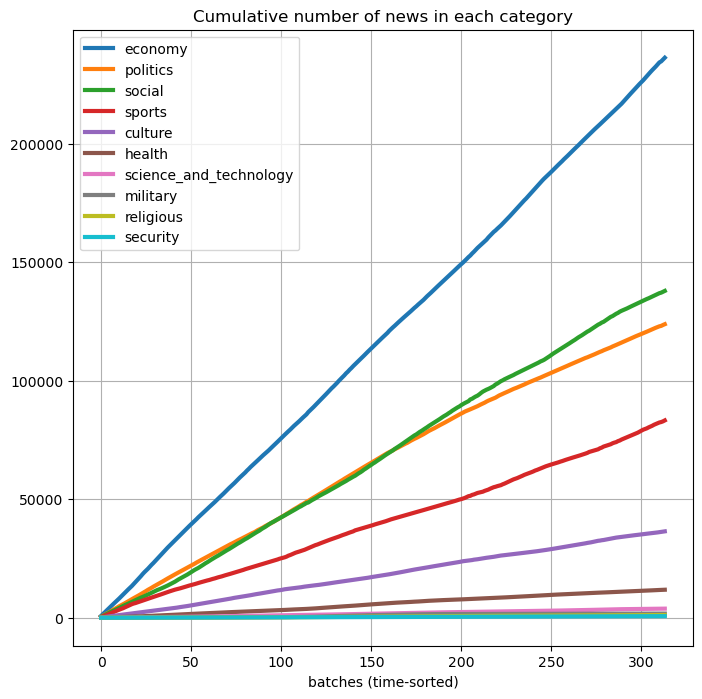

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Cumulative number of news in each category')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(category_count_timeline[category], label=category, linewidth=3)
plt.legend(loc='upper left')
plt.grid()
plt.show()

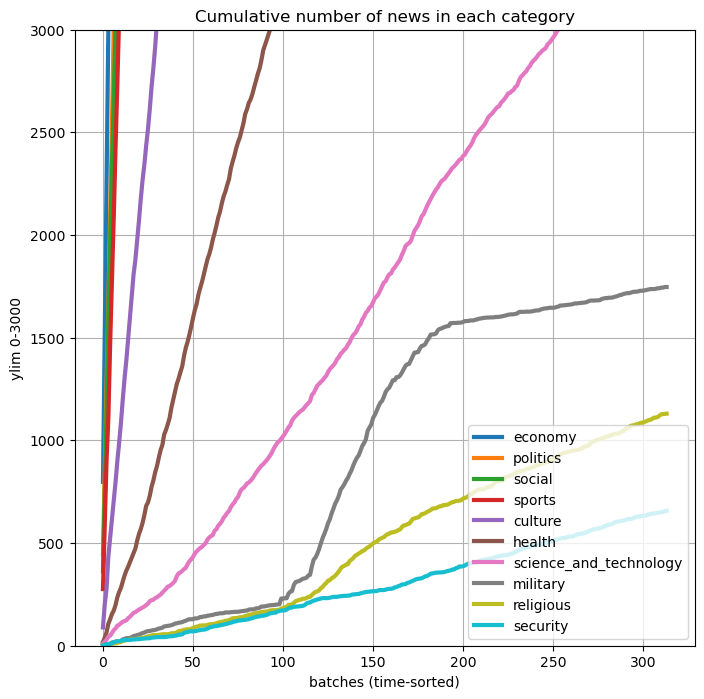

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Cumulative number of news in each category')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(category_count_timeline[category], label=category, linewidth=3)
plt.legend(loc='lower right')
plt.ylim(0,3000)
plt.ylabel('ylim 0-3000')
plt.grid()
plt.show()

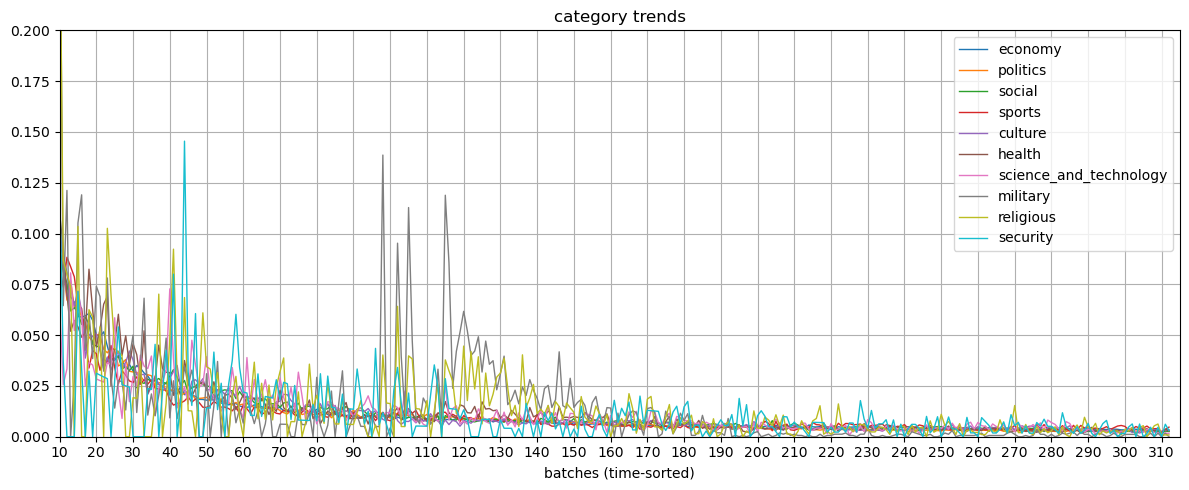

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('category trends')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(np.diff(category_count_timeline[category])/category_count_timeline[category][:-1], label=category, linewidth=1)
plt.legend(loc='upper right')
plt.ylim(0,0.2)
plt.xlim(10,315)
plt.xticks(range(10,316, 10))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
news95 = pd.read_json('streamdata/stream_part95.jsonl', lines=True)
news190 = pd.read_json('streamdata/stream_part190.jsonl', lines=True)

In [ ]:
print('Peak started from:\t', datetime.fromtimestamp(news95['date_published'].min()))
print('Peak finished in:\t', datetime.fromtimestamp(news190['date_published'].max()))

Peak started from:	 2023-10-08 08:34:00
Peak finished in:	 2023-11-05 08:36:35


![Google Search Result](https://drive.google.com/uc?id=1y3AFD-aIEeiJLyzDMptg8k37KNMkpzfJ)

In [ ]:
news115 = pd.read_json('streamdata/stream_part115.jsonl', lines=True)
print('Second Peak started from:\t', datetime.fromtimestamp(news115['date_published'].min()))
print('Second Peak finished in:\t', datetime.fromtimestamp(news115['date_published'].max()))

Second Peak started from:	 2023-10-23 12:16:00
Second Peak finished in:	 2023-11-05 12:09:20


***
# $\text{Step 2}$

In [ ]:
news = pd.read_json('news_data.jsonl', lines=True)

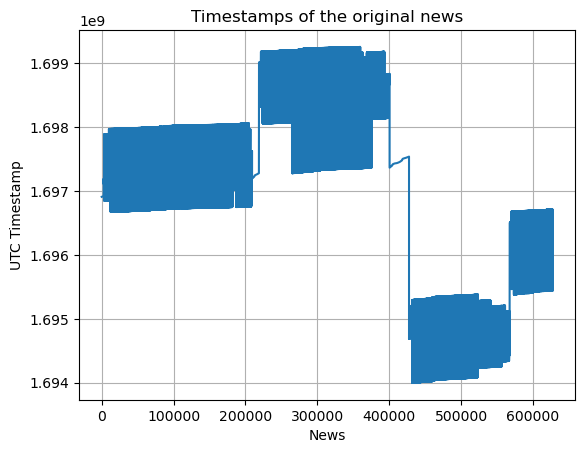

In [ ]:
news['date_published'].plot()
plt.title('Timestamps of the original news')
plt.xlabel('News')
plt.ylabel('UTC Timestamp')
plt.grid()
plt.show()

In [ ]:
news.sort_values(by=['date_published'], inplace=True)

In [ ]:
news = news.reset_index(drop=True)

In [ ]:
news.to_json('news_data_sorted.jsonl', orient='records', lines=True, force_ascii=False)

In [ ]:
news_sorted = pd.read_json('news_data_sorted.jsonl', lines=True)

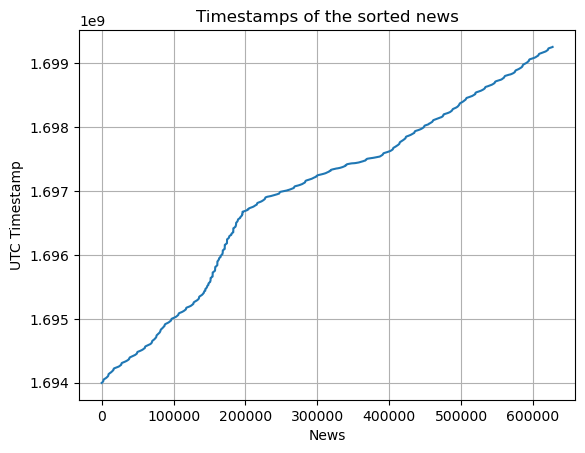

In [ ]:
news_sorted['date_published'].plot()
plt.title('Timestamps of the sorted news')
plt.xlabel('News')
plt.ylabel('UTC Timestamp')
plt.grid()
plt.show()

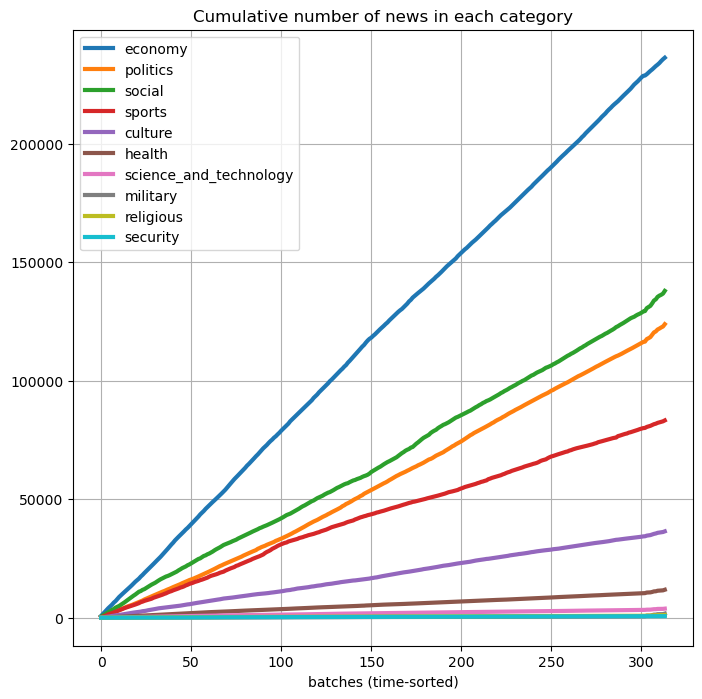

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Cumulative number of news in each category')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(category_count_timeline[category], label=category, linewidth=3)
plt.legend(loc='upper left')
plt.grid()
plt.show()

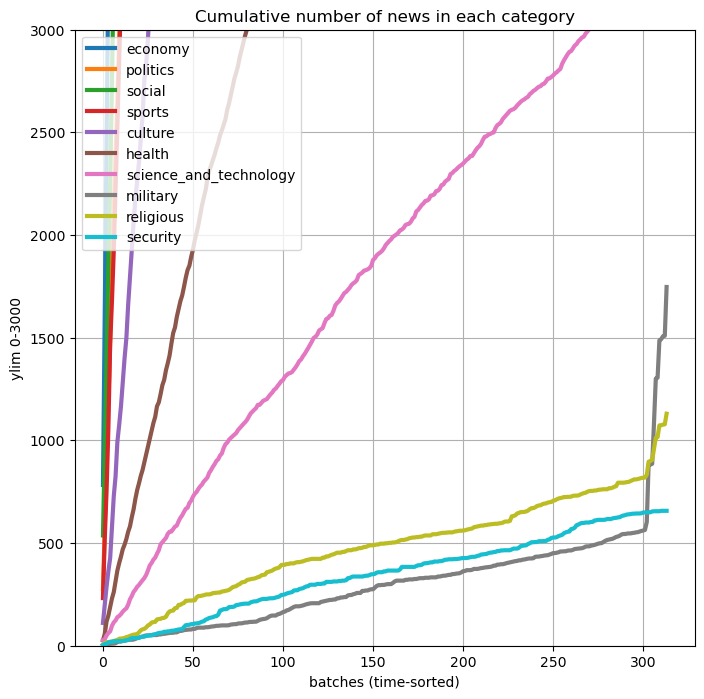

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Cumulative number of news in each category')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(category_count_timeline[category], label=category, linewidth=3)
plt.legend(loc='upper left')
plt.ylim(0,3000)
plt.ylabel('ylim 0-3000')
plt.grid()
plt.show()

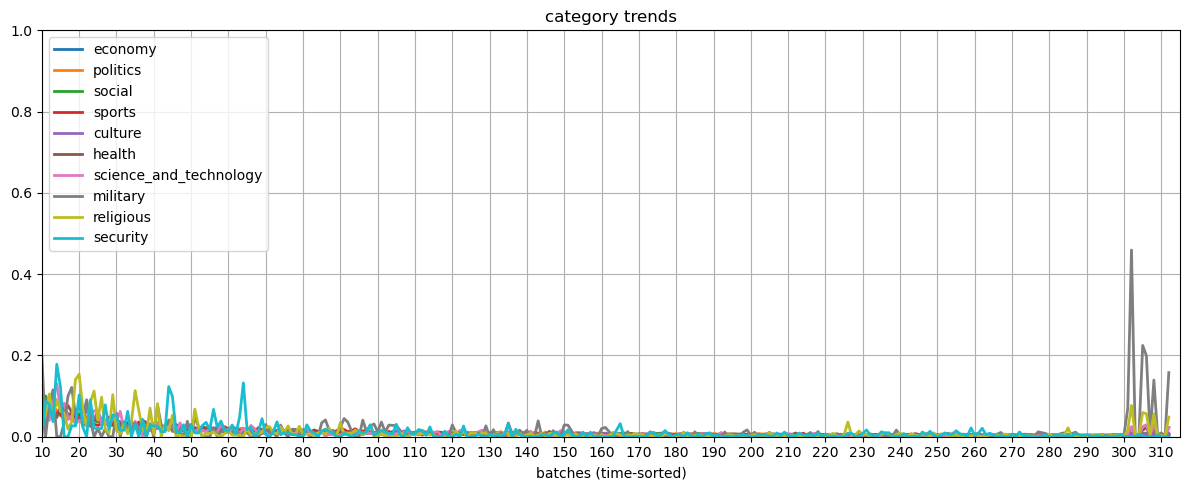

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('category trends')
plt.xlabel('batches (time-sorted)')
for category in categories:
    plt.plot(np.diff(category_count_timeline[category])/category_count_timeline[category][:-1], label=category, linewidth=2)
plt.legend(loc='upper left')
plt.ylim(0,0.1)
plt.xlim(10,315)
plt.xticks(range(10,316, 10))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
news302 = pd.read_json('streamdata/stream_part302.jsonl', lines=True)
news312 = pd.read_json('streamdata/stream_part312.jsonl', lines=True)

In [ ]:
print('Peak started from:\t', datetime.fromtimestamp(news302['date_published'].min()))
print('Peak finished in:\t', datetime.fromtimestamp(news312['date_published'].max()))

Peak started from:	 2023-11-04 11:46:28
Peak finished in:	 2023-11-06 05:59:44


In [ ]:
count = 10
for body in news302[news302['categories'].map(lambda x: 'military' in x)]['body']:
    print(body, end='\n'+'='*100+'\n')
    count -= 1
    if count == 0:
        break

خبرگزاری آریا - گردان های قسام اعلام کرد که در درگیری با یک گروه از نظامیان صهیونیست در شمال غربی شهر غزه 5 تفر از آنها کشته شدند.

العالم ـ فلسطین اشغالی

بنابر این گزارش، گردانهای قسام شاخه نظامی جنبش حماس، با انتشار اطلاعیهای نظامی اعلام کرد که مجاهدان این گردانها امروز (شنبه) به یک گروه از نظامیان صهیونیست در شمال غربی شهر غزه حمله کرده و با تیربار و نارنجک با آنان درگیر شدند.

این گردانها خاطرنشان کرد که در این حمله 5 نظامی صهیونیست کشته و تعدادی نیز زخمی شدند.
در بیانیه گردانهای قسام آمده که "نیروهای ما به یگان ارتش رژیم صهیونیستی مستقر در ساختمانی در شمال غرب شهر غزه حمله کردند".

به گزارش الجزیره، در ادامه این بیانیه آمده است: با این یگان درگیر شدیم و ۵ نظامی را کشتیم و تعدادی دیگر را زخمی کردیم.

گردانهای القسام شهر اشغالی "ایلات" را موشکباران کردند

حمایت غرب از رژیم صهیونیستی به بهانه دفاع از خود، عملا چراغ سبز و مجوزی برای تل آویو در ادامه کشتار بیرحمانه کودکان و زنان فلسطینی است.

نگرانیهای جهانی به فاجعه انسانی و کشتار بی ترحم مردم غزه و درخواستها برای متوقف کردن ماشین کش

***
# $\text{Step 3}$

In [ ]:
kwrds_count = news.select(count_if(col('body').contains('غزه')).alias('count_keyword'))

In [ ]:
query = kwrds_count.writeStream.format('console').outputMode('complete').start(truncate=False)

24/02/05 15:25:52 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-c5bf1bb3-a20e-4211-b99f-4335505d1028. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/02/05 15:25:52 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-------------+
|count_keyword|
+-------------+
|3            |
+-------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-------------+
|count_keyword|
+-------------+
|7            |
+-------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-------------+
|count_keyword|
+-------------+
|16           |
+-------------+

-------------------------------------------
Batch: 3
-------------------------------------------
+-------------+
|count_keyword|
+-------------+
|20           |
+-------------+

-------------------------------------------
Batch: 4
-------------------------------------------
+-------------+
|count_keyword|
+-------------+
|24           |
+-------------+

-------------------------------------------
Batch: 5
-------------------------------------------
+------------

In [ ]:
with open('keyword_stream_log.txt', 'r') as f:
    lines = f.readlines()
log = ''.join(lines)

In [ ]:
keyword_count_timeline = list()
splitted = log.split('count_keyword')
keyword_count_timeline = [int(s.strip().split('|')[2]) for s in splitted[1:]]

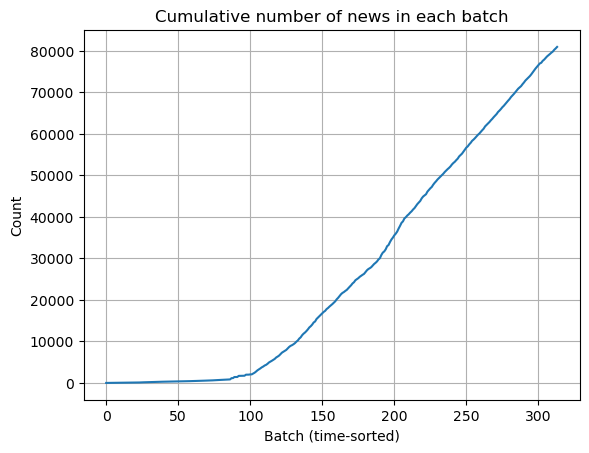

In [ ]:
plt.plot(keyword_count_timeline)
plt.title('Cumulative number of news in each batch')
plt.xlabel('Batch (time-sorted)')
plt.ylabel('Count')
plt.grid()
plt.show()

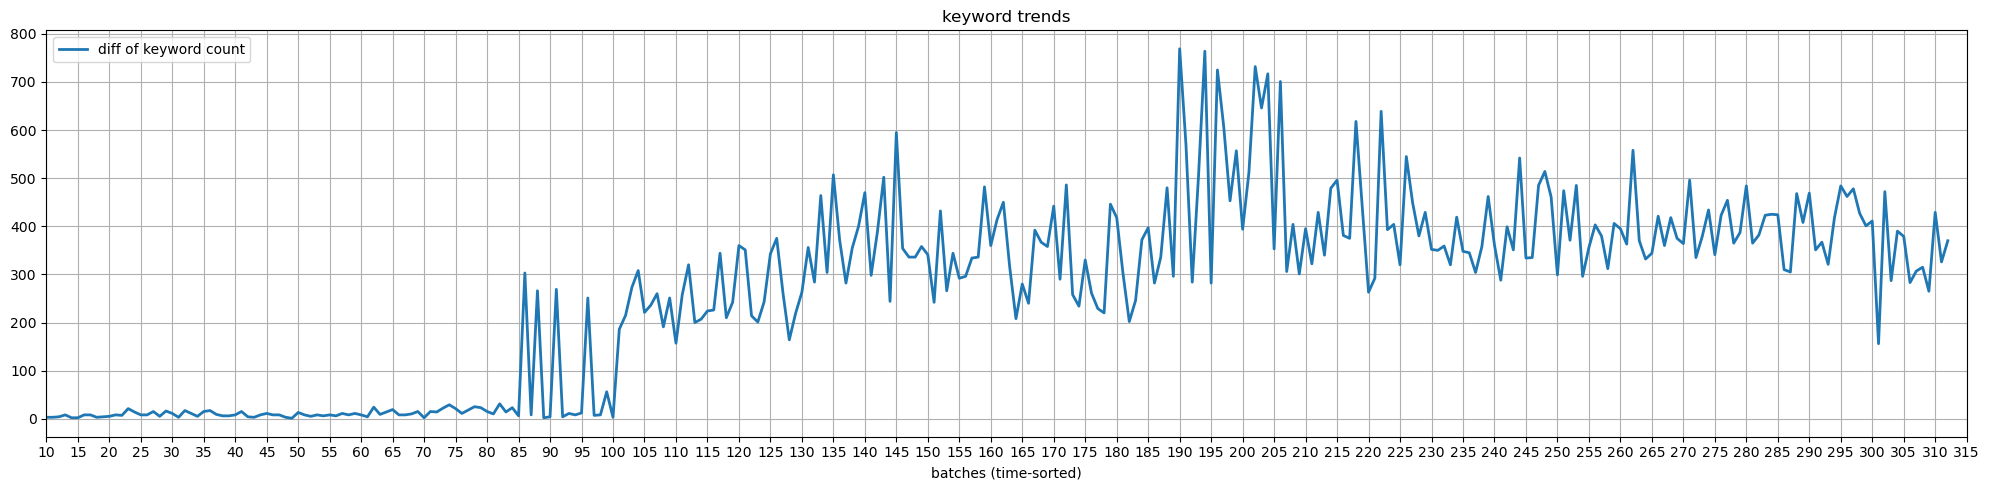

In [ ]:
plt.figure(figsize=(20, 5))
plt.title('keyword trends')
plt.xlabel('batches (time-sorted)')
plt.plot(np.diff(keyword_count_timeline), label='diff of keyword count', linewidth=2)
plt.legend(loc='upper left')
# plt.ylim(0,0.5)
plt.xlim(10,315)
plt.xticks(range(10,316, 5))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from datetime import datetime
news100 = pd.read_json('streamdata/stream_part100.jsonl', lines=True)
news312 = pd.read_json('streamdata/stream_part312.jsonl', lines=True)
print('First Peak started from:', datetime.fromtimestamp(news100['date_published'].min()))
print('First Peak finished in:\t', datetime.fromtimestamp(news312['date_published'].max()))

First Peak started from: 2023-10-07 16:00:00
First Peak finished in:	 2023-11-06 05:59:44


![Google Search Result](https://drive.google.com/uc?id=1y3AFD-aIEeiJLyzDMptg8k37KNMkpzfJ)

In [ ]:
news190 = pd.read_json('streamdata/stream_part190.jsonl', lines=True)
news195 = pd.read_json('streamdata/stream_part195.jsonl', lines=True)
print('Second Peak started from:\t', datetime.fromtimestamp(news190['date_published'].min()))
print('Second Peak finished in:\t', datetime.fromtimestamp(news195['date_published'].max()))

Second Peak started from:	 2023-10-17 07:38:41
Second Peak finished in:	 2023-10-18 01:52:49


![Google Search Result](https://drive.google.com/uc?id=1JK2ybI9dxgPJOTO1SctXQVurcGMl-0Jr)